# **Data-Science Fundamentals Final Project: predicting flights using ML algorithms**

## Stage No. 1: collecting the data:
- for this stage we will use a web scraper-collector that will collect flights data from two websites: Kiwi and Kayak.
- this collector is built with async-runtime functions, random user-actions generator, session saver, cookies saver, dynamic viewport and even DHCP-ip-refresher function (since were not using proxy), all of these methods are used for collecting without getting cought by these websities bot-identifier machenisms...
- this collector will run every combination of ttt (time to travel) from 1-30, los (lenght of stay) from 1-5 within a 3 different snapshot days for every combination of rome,london and paris routes

In [105]:
%pip install -e scraping
# %playwright install

Obtaining file:///C:/Users/Nadav/DS-Scarping/scraping
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for scraping
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
# from scraping.flights_scraping import get_data

# get_data()

After we have collected the data: were doing the usual imports:

In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, time, random, datetime, math
from datetime import datetime
from tqdm import tqdm

##################### Preprocessing imports 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder, HashingEncoder, CountEncoder
from sklearn.impute import KNNImputer

##################### Metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

##################### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import skew, kurtosis

##################### optuna library import
# !pip install shap
import optuna
# import shap
import matplotlib.cm as cm
from collections import defaultdict
from currency_converter import CurrencyConverter

##################### Basic settings
random_state = 42
n_splits = 5

## Stage 2: Exploring the data

In [7]:
data = pd.read_csv('Flights.csv')

In [8]:
# Table for first look
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    return sum

display(summary(data).style.background_gradient(cmap='Blues'))
data.head()

departure_hour departure_airport flight_length landing_hour landing_airport  \
0          6:00a               CIA        2h 45m        7:45a             STN   
1          6:35a               FCO        2h 45m        8:20a             LGW   
2          6:35a               FCO        2h 45m        8:20a             LGW   
3          6:00a               CIA        2h 45m        7:45a             STN   
4            NaN               NaN           NaN          NaN             NaN   

  to_dest_company return_departure_hour return_departure_airport  \
0         Ryanair                 6:10p                      STN   
1        Wizz Air                 9:10a                      STN   
2        Wizz Air                 6:10p                      STN   
3         Ryanair                 6:10p                      STN   
4             NaN                   NaN                      NaN   

  return_flight_length return_landing_hour  ... ttt los snapshot_date  \
0               2h 25m               9:35p  ...   2   1    2025-02-28   
1               2h 30m              12:40p  ...   2   1    2025-02-28   
2               2h 25m               9:35p  ...   2   1    2025-02-28   
3               2h 25m               9:35p  ...   2   1    2025-02-28   
4                  NaN                 NaN  ...   2   1    2025-02-28   

   origin_city  destination_city  departure_date return_date website  \
0         ROME            LONDON      2025-03-02  2025-03-03   Kayak   
1         ROME            LONDON      2025-03-02  2025-03-03   Kayak   
2         ROME            LONDON      2025-03-02  2025-03-03   Kayak   
3         ROME            LONDON      2025-03-02  2025-03-03   Kayak   
4         ROME            LONDON      2025-03-02  2025-03-03   Kayak   

  layover_time return_layover_time  
0           0m                  0m  
1           0m                  0m  
2           0m                  0m  
3           0m                  0m  
4           0m                  0m  

[5 rows x 24 columns]

## Stage 3: Preprocessing
<!-- <ul>
    <li>basic_cleanups</li>
    <li></li>
    <li></li>
</ul> -->

the price is still an object! we need to convert it to numerical... (with scraping knowlage we know that kiwi gives the price in nis and kayak in $)

In [110]:
%pip install currencyconverter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
def basic_cleanups(data):
    data = data.drop_duplicates()
    data = data.dropna()

    c = CurrencyConverter()

    data['price'] = data['price'].apply(
        lambda x: (
            c.convert(float(x.replace('₪ ', '').replace(',', '')), 'ILS', 'USD') if '₪ ' in x
            else float(x.replace('$', '').replace(',', '')) if '$' in x 
            else None 
        )
    )
    return data

we will add a function that will convert the time strings to int (in minutes)

In [10]:
def time_to_minutes(time_str: str)-> int:
    if pd.isna(time_str):
        return 0

    # Extract hours and minutes using regex
    hours = 0
    minutes = 0
    
    h_match = re.search(r'(\d+)h', time_str)
    m_match = re.search(r'(\d+)m', time_str)

    if h_match:
        hours = int(h_match.group(1))
    if m_match:
        minutes = int(m_match.group(1))

    return hours * 60 + minutes

In [4]:
def hour_to_numeric(hour_str):
    '''
    convert the hours to int format
    '''
    hour_str = hour_str.strip()  

    match = re.search(r"\+(\d+)", hour_str)
    extra_days = int(match.group(1)) if match else 0
    hour_str = re.sub(r"\+\d+", "", hour_str)
    
    if 'a' in hour_str or 'p' in hour_str:
        hour_str = hour_str.replace('a', 'AM').replace('p', 'PM')

        time_obj = datetime.strptime(hour_str, "%I:%M%p")
    else:
        time_obj = datetime.strptime(hour_str, "%H:%M")

    hour_float = time_obj.hour + time_obj.minute / 60

    hour_float += extra_days * 24

    return hour_float


In [11]:
def preprocessing(data):
    # perform basic cleanups
    data = basic_cleanups(data)

    # convert time to minutes
    data['flight_length'] = data['flight_length'].apply(time_to_minutes)
    data['return_flight_length'] = data['return_flight_length'].apply(time_to_minutes)
    data['layover_time'] = data['layover_time'].apply(time_to_minutes)
    data['return_layover_time'] = data['return_layover_time'].apply(time_to_minutes)

    # convert hours to numeric
    data['departure_hour'] = data['departure_hour'].apply(hour_to_numeric)
    data['landing_hour'] = data['landing_hour'].apply(hour_to_numeric)
    data['return_departure_hour'] = data['return_departure_hour'].apply(hour_to_numeric)
    data['return_landing_hour'] = data['return_landing_hour'].apply(hour_to_numeric)

    # convert date to datetime
    ## we know that dates are tied to day of week, lets create new feature based on the departure date!
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    data['day_of_week'] = data['departure_date'].dt.day_name()

    # create new feature based on the origin_city and destination_city
    data['route'] = data['origin_city'] + '_' + data['destination_city']

    return data

data = preprocessing(data)
data.head()

departure_hour departure_airport  flight_length  landing_hour  \
0        6.000000               CIA            165      7.750000   
1        6.583333               FCO            165      8.333333   
2        6.583333               FCO            165      8.333333   
5        6.583333               FCO            165      8.333333   
6        6.583333               FCO            165      8.333333   

  landing_airport to_dest_company  return_departure_hour  \
0             STN         Ryanair              18.166667   
1             LGW        Wizz Air               9.166667   
2             LGW        Wizz Air              18.166667   
5             LGW        Wizz Air              21.000000   
6             LGW        Wizz Air               6.250000   

  return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                      STN                   145            21.583333  ...   
1                      STN                   150            12.666667  ...   
2                      STN                   145            21.583333  ...   
5                      LGW                   150            24.500000  ...   
6                      STN                   145             9.666667  ...   

  snapshot_date origin_city  destination_city  departure_date  return_date  \
0    2025-02-28        ROME            LONDON      2025-03-02   2025-03-03   
1    2025-02-28        ROME            LONDON      2025-03-02   2025-03-03   
2    2025-02-28        ROME            LONDON      2025-03-02   2025-03-03   
5    2025-02-28        ROME            LONDON      2025-03-02   2025-03-03   
6    2025-02-28        ROME            LONDON      2025-03-02   2025-03-03   

   website layover_time return_layover_time day_of_week        route  
0    Kayak            0                   0      Sunday  ROME_LONDON  
1    Kayak            0                   0      Sunday  ROME_LONDON  
2    Kayak            0                   0      Sunday  ROME_LONDON  
5    Kayak            0                   0      Sunday  ROME_LONDON  
6    Kayak            0                   0      Sunday  ROME_LONDON  

[5 rows x 26 columns]

We have find a mistake in the dataset where there are a lot of invalid values inside of the feature return_departure_airport - Some of the values (around 80-90K values) only contain an hour. Therefore the best direction at the moment is to turn all the invalid values to Nans 

In [12]:
value_counts = data['return_departure_airport'].value_counts()

# Temporarily increase the maximum rows to display
with pd.option_context('display.max_rows', None):
    print(value_counts)

return_departure_airport
FCO      82301
ORY      72126
LGW      71877
CDG      49974
STN      28977
LHR      14249
LTN      14221
CIA      12458
BVA       9537
11:35     1928
11:50     1917
08:20     1874
17:45     1791
09:20     1700
08:35     1359
12:50     1359
10:15     1346
07:45     1312
14:25     1251
18:25     1232
09:10     1219
12:35     1207
09:25     1195
SEN       1139
10:35     1125
08:40     1095
20:20     1024
23:15      993
08:25      953
LCY        953
16:55      933
22:30      928
12:40      910
21:45      887
08:55      868
19:50      855
08:05      797
15:20      754
20:05      750
15:25      745
09:40      741
21:40      738
08:10      719
07:30      713
12:05      703
19:40      697
19:35      694
19:05      665
17:20      661
16:20      636
11:00      629
20:30      624
18:50      612
18:55      600
19:25      598
12:25      588
10:20      585
13:20      584
09:30      573
10:40      563
21:35      559
21:50      552
16:05      551
19:30      549
11:10      543


In [13]:
def replace_time_with_nan(df, column_name):
    """Replaces time patterns (HH:MM) in a specified DataFrame column with NaN."""

    time_pattern = r'^\d{2}:\d{2}$'  # Matches HH:MM format (e.g., 11:35)

    df[column_name] = df[column_name].replace(to_replace=time_pattern, value=np.nan, regex=True)

    return df

replace_time_with_nan(data,'return_departure_airport')

departure_hour departure_airport  flight_length  landing_hour  \
0             6.000000               CIA            165      7.750000   
1             6.583333               FCO            165      8.333333   
2             6.583333               FCO            165      8.333333   
5             6.583333               FCO            165      8.333333   
6             6.583333               FCO            165      8.333333   
...                ...               ...            ...           ...   
493306        7.000000               CDG             80      7.333333   
493307        7.000000               ORY             70      7.166667   
493308        9.916667               CDG             80     10.250000   
493309        7.000000               CDG             80      7.333333   
493310        7.000000               ORY             70      7.166667   

       landing_airport to_dest_company  return_departure_hour  \
0                  STN         Ryanair              18.166667   
1                  LGW        Wizz Air               9.166667   
2                  LGW        Wizz Air              18.166667   
5                  LGW        Wizz Air              21.000000   
6                  LGW        Wizz Air               6.250000   
...                ...             ...                    ...   
493306             LTN         easyJet              13.416667   
493307             LGW         Vueling              14.333333   
493308             LTN         easyJet              20.250000   
493309             LTN         easyJet              19.583333   
493310             LGW         Vueling              15.250000   

       return_departure_airport  return_flight_length  return_landing_hour  \
0                           STN                   145            21.583333   
1                           STN                   150            12.666667   
2                           STN                   145            21.583333   
5                           LGW                   150            24.500000   
6                           STN                   145             9.666667   
...                         ...                   ...                  ...   
493306                      NaN                    80            15.750000   
493307                      NaN                    70            16.500000   
493308                      NaN                    75            22.500000   
493309                      NaN                    80            21.916667   
493310                      NaN                    90            17.750000   

        ... snapshot_date origin_city  destination_city  departure_date  \
0       ...    2025-02-28        ROME            LONDON      2025-03-02   
1       ...    2025-02-28        ROME            LONDON      2025-03-02   
2       ...    2025-02-28        ROME            LONDON      2025-03-02   
5       ...    2025-02-28        ROME            LONDON      2025-03-02   
6       ...    2025-02-28        ROME            LONDON      2025-03-02   
...     ...           ...         ...               ...             ...   
493306  ...    2025-03-02       PARIS            LONDON      2025-03-16   
493307  ...    2025-03-02       PARIS            LONDON      2025-03-16   
493308  ...    2025-03-02       PARIS            LONDON      2025-03-16   
493309  ...    2025-03-02       PARIS            LONDON      2025-03-16   
493310  ...    2025-03-02       PARIS            LONDON      2025-03-16   

        return_date  website layover_time return_layover_time day_of_week  \
0        2025-03-03    Kayak            0                   0      Sunday   
1        2025-03-03    Kayak            0                   0      Sunday   
2        2025-03-03    Kayak            0                   0      Sunday   
5        2025-03-03    Kayak            0                   0      Sunday   
6        2025-03-03    Kayak            0                   0      Sunday   
...             ...      ...          ...         

## Stage 4 - EDA
<ul>
    <li>Target Column</li>
    <li></li>
</ul>

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


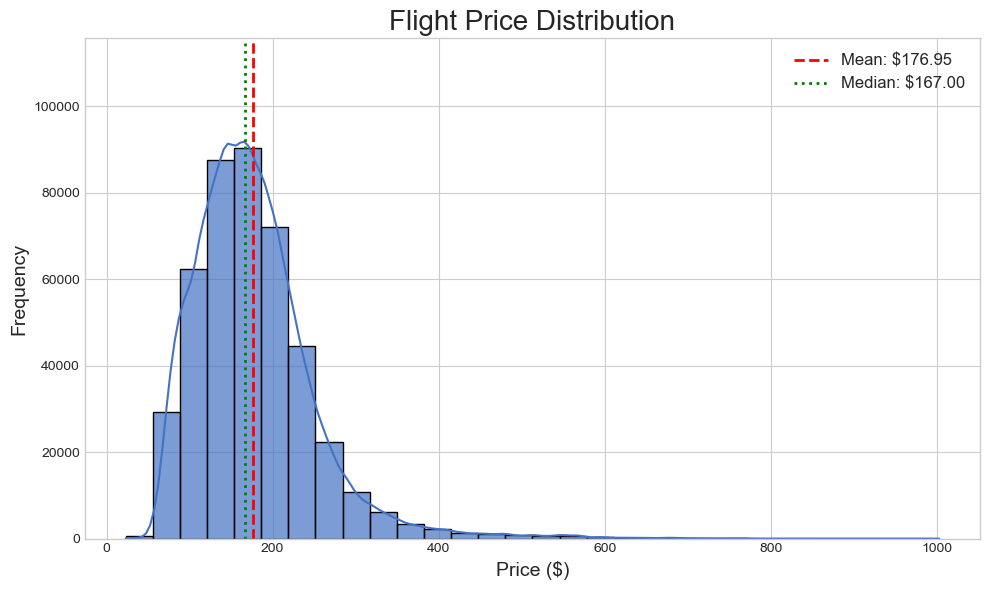

The target variable kurtosis is 6.22985229583405
The target variable skew is 1.7049776125112948


In [117]:
def TargetCol(data): 
    '''Target column analysis - which in this case is the price column distribution'''
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6))
    plt.title('Flight Price Distribution', fontsize=20)

    sns.histplot(data['price'], bins=30, kde=True, color='#4472C4', 
                edgecolor='black', alpha=0.7)

    mean_price = data['price'].mean()
    median_price = data['price'].median()
    plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${mean_price:.2f}')
    plt.axvline(median_price, color='green', linestyle=':', linewidth=2, 
                label=f'Median: ${median_price:.2f}')

    plt.ylim(0, plt.ylim()[1] * 1.2)

    plt.xlabel('Price ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"The target variable kurtosis is {kurtosis(data['price'])}")
    print(f"The target variable skew is {skew(data['price'])}")
    
TargetCol(data)

The results of the kurtosis and skew mean that the price target 

In [118]:
data_value_counts = data['to_dest_company'].value_counts()
data_value_counts = pd.DataFrame(data_value_counts).style.background_gradient("cool")
data_value_counts

There is A lot of data 

In [14]:
company_mapping = {
    'Wizz Air Malta': 'Wizz Air',
    'Wizz Air UK': 'Wizz Air',
    'Ryanair UK': 'Ryanair',
    'Multiple airlines': 'Other',
    'Scandinavian Airlines': 'SAS',
    'KM Malta Airlines': 'Other',
    'Aeroitalia': 'Other',
    'FlixBus': 'Other',
    'BlaBlaBus': 'Other',
    'Union Ivkoni': 'Other',
    'Brussels Airlines': 'Other',
    'SWISS': 'Other',
    'Volotea': 'Other'
}

data['to_dest_company'] = data['to_dest_company'].replace(company_mapping)
data['return_company'] = data['return_company'].replace(company_mapping)

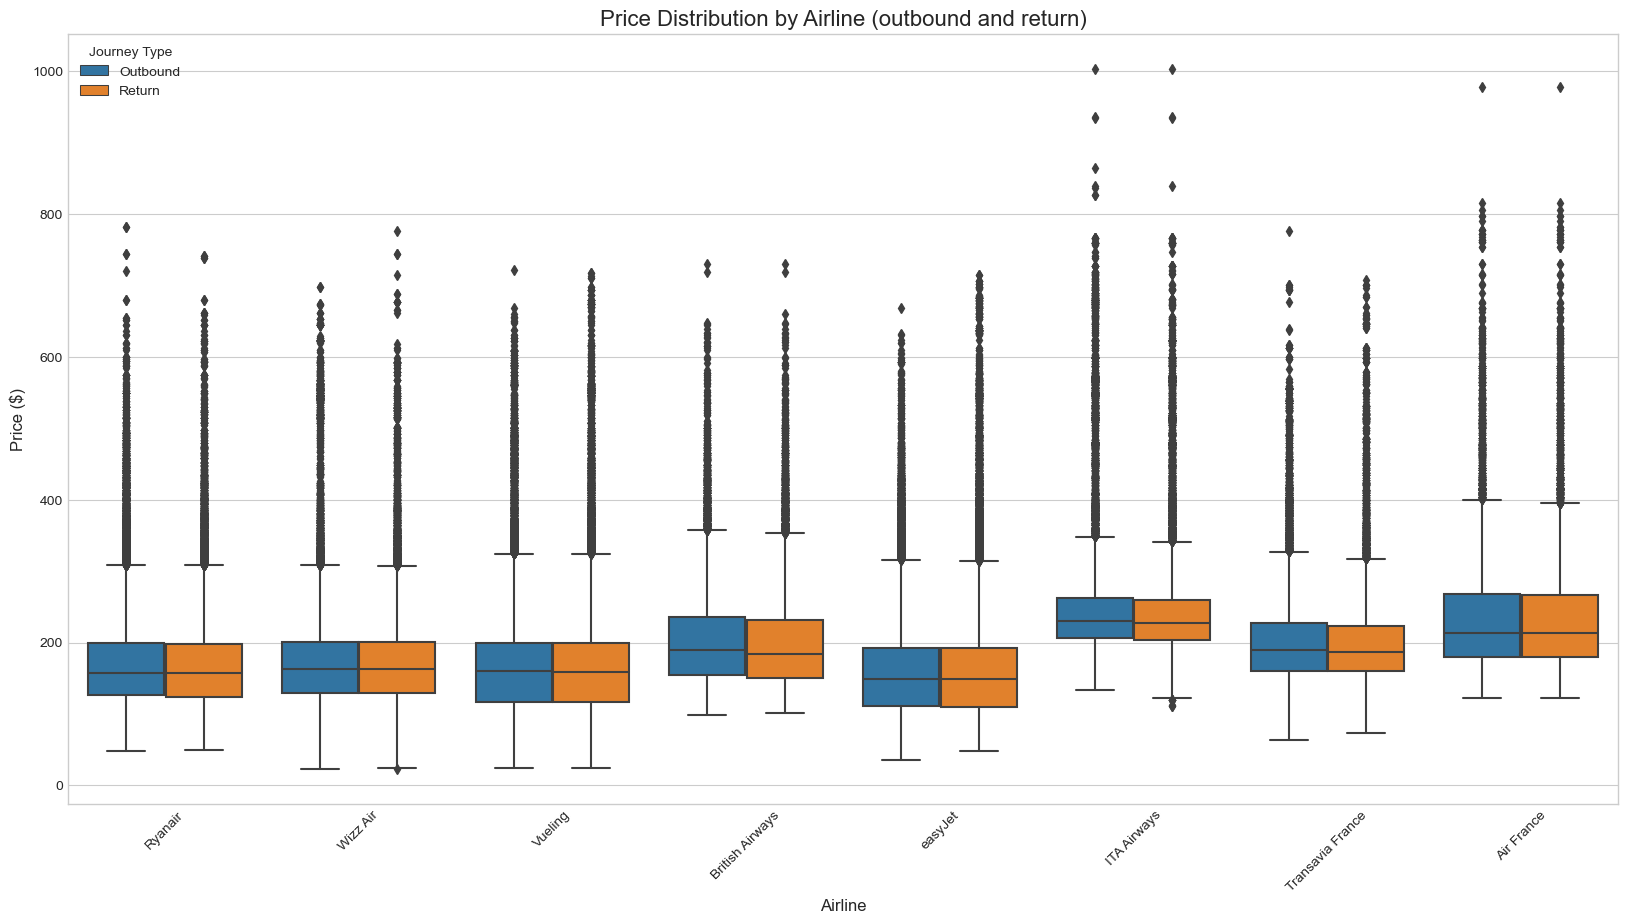

In [120]:
def price_per_airline(data):
    '''visualize dist of price per airway company (outbound and return)'''
    
    plt.figure(figsize=(20, 10))

    outbound_data = data[['price', 'to_dest_company']].copy()
    outbound_data['journey_type'] = 'Outbound'
    outbound_data.rename(columns={'to_dest_company': 'company'}, inplace=True)

    return_data = data[['price', 'return_company']].copy()
    return_data['journey_type'] = 'Return'
    return_data.rename(columns={'return_company': 'company'}, inplace=True)

    combined_data = pd.concat([outbound_data, return_data])

    # Get the top 10 most frequent airlines
    top_airlines = combined_data['company'].value_counts().nlargest(8).index.tolist()
    combined_data_filtered = combined_data[combined_data['company'].isin(top_airlines)]

    sns.boxplot(x='company', y='price', hue='journey_type', data=combined_data_filtered)
    plt.xlabel('Airline', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title('Price Distribution by Airline (outbound and return)', fontsize=16)
    plt.xticks(rotation=45)
    plt.legend(title='Journey Type')

price_per_airline(data)

now lets visualize the price per city (origin, destination anf total route)

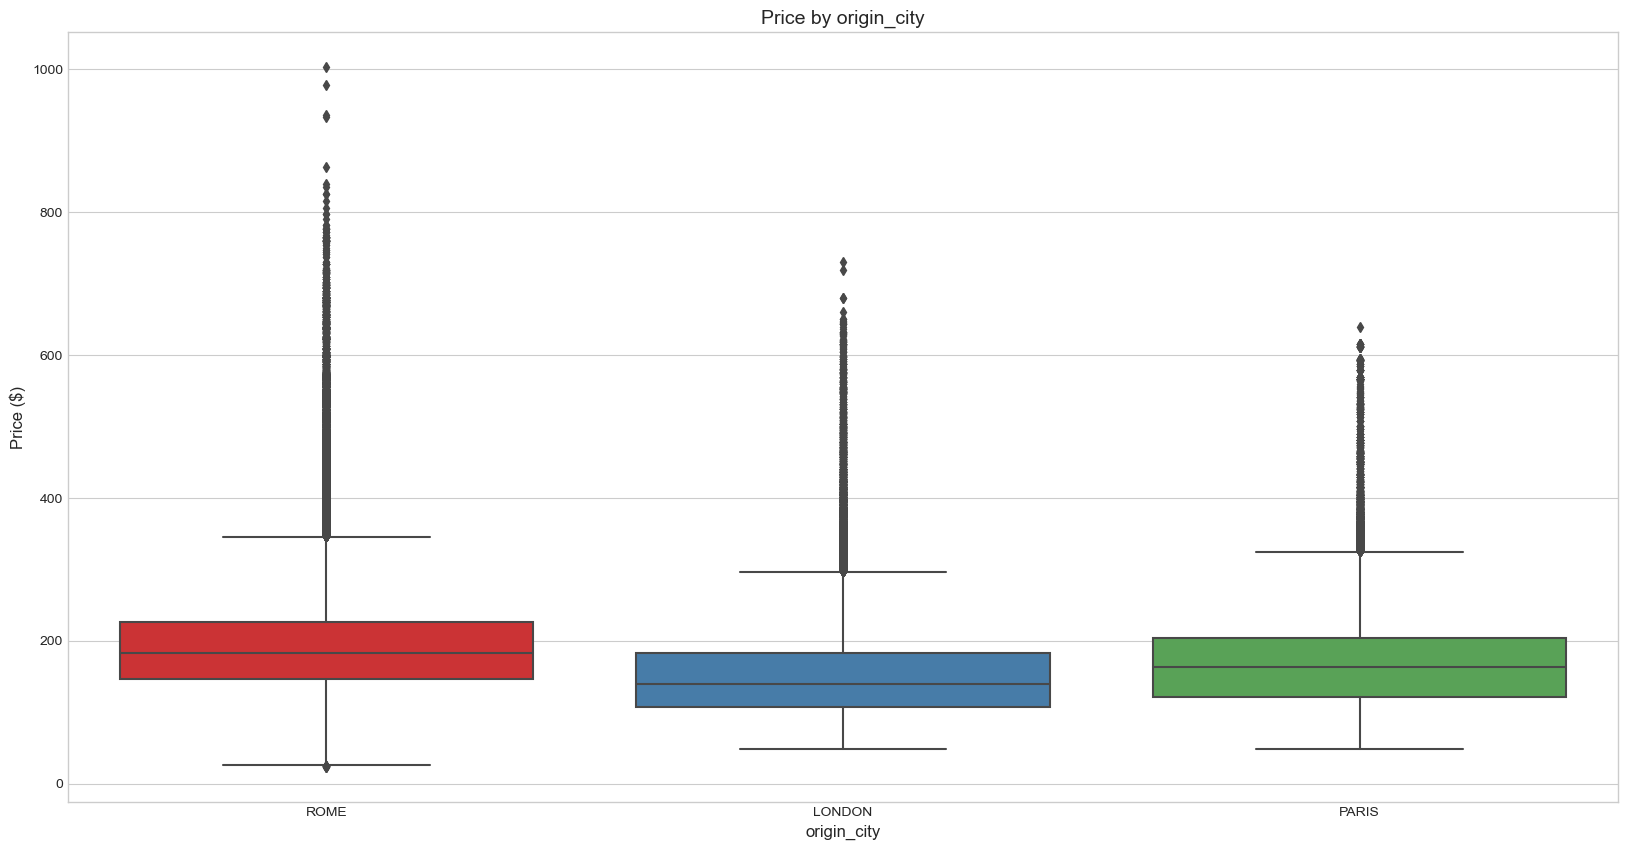

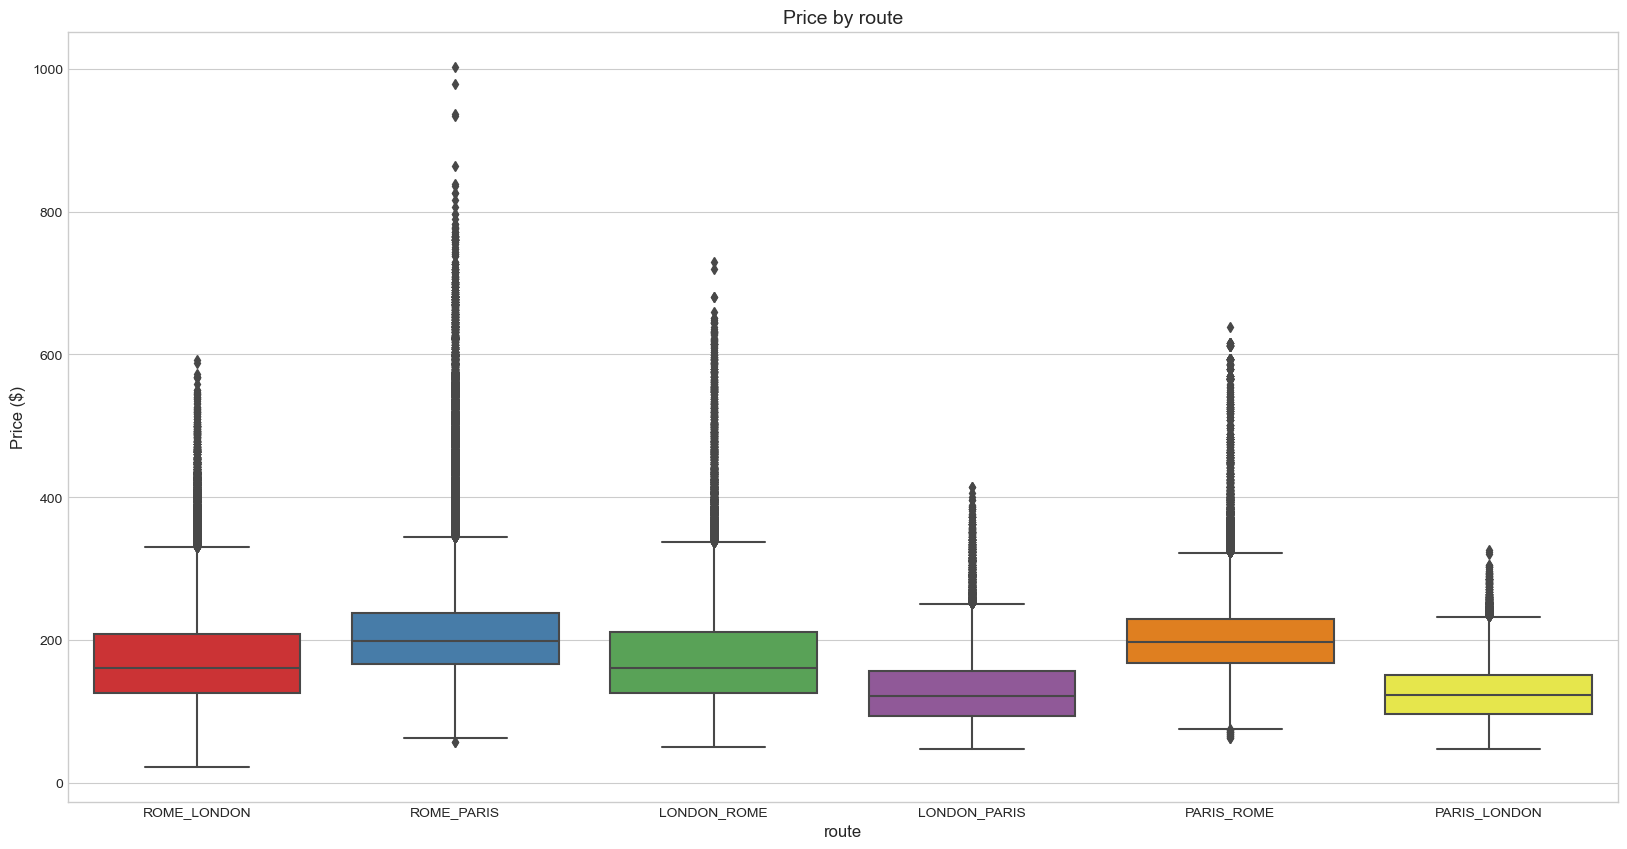

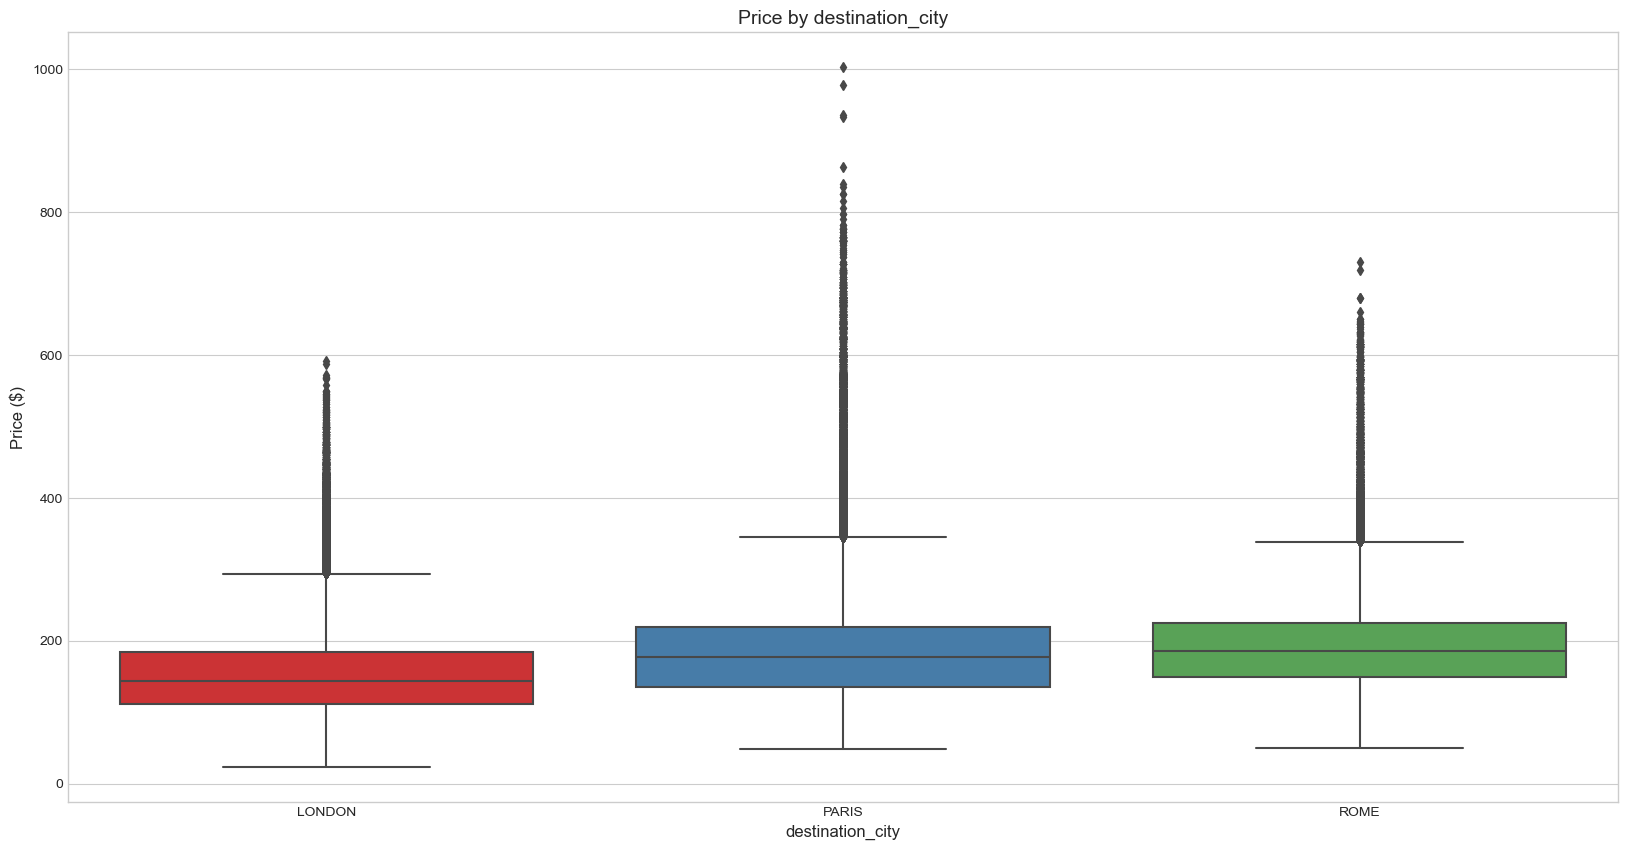

In [121]:
def price_per_feature(data, column: str):
    plt.figure(figsize=(20, 10))
    top_routes = data[column].value_counts().index.tolist()
    cities_data = data[data[column].isin(top_routes)]

    sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')
    plt.title(f'Price by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    
price_per_feature(data, 'origin_city')
price_per_feature(data, 'route')
price_per_feature(data, 'destination_city')

### Insights
- Rome is the most expensive distination to fly from and to, We can infer that the reason for the higher prices in Rome come from the fact that it is the most toured (trip with rome as destination is much more common then a trip with rome as outbound)
- the route of london to paris (and paris to london) is the cheapest, we can infer it because these cities are close to each other

### let check out the companies 

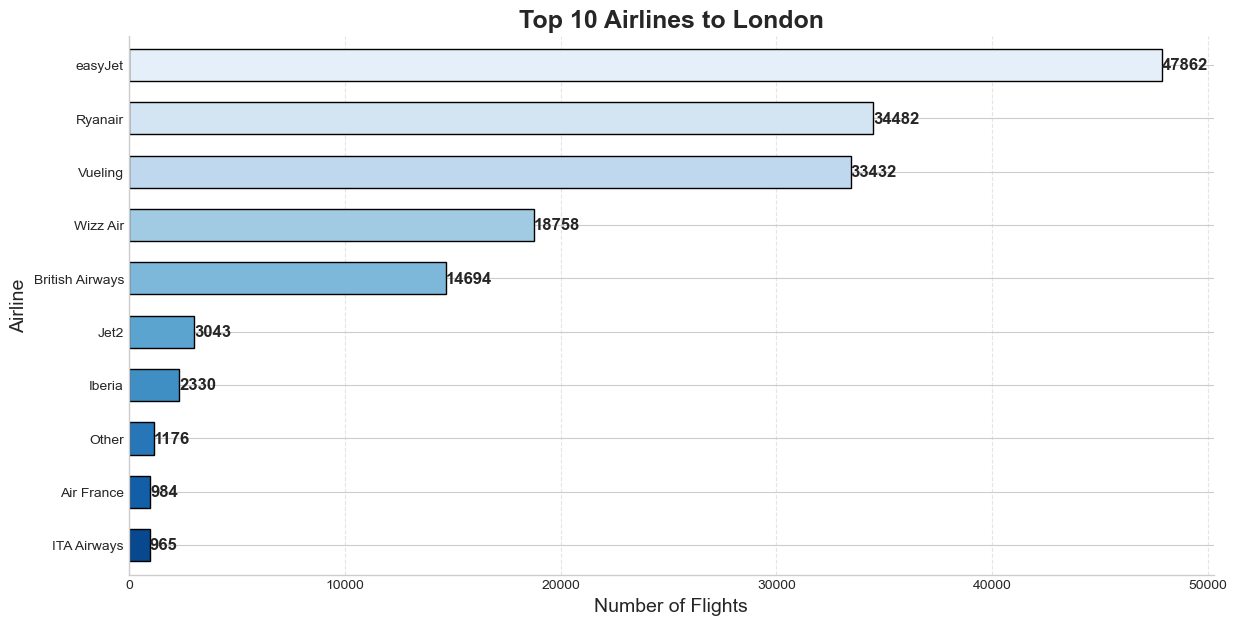

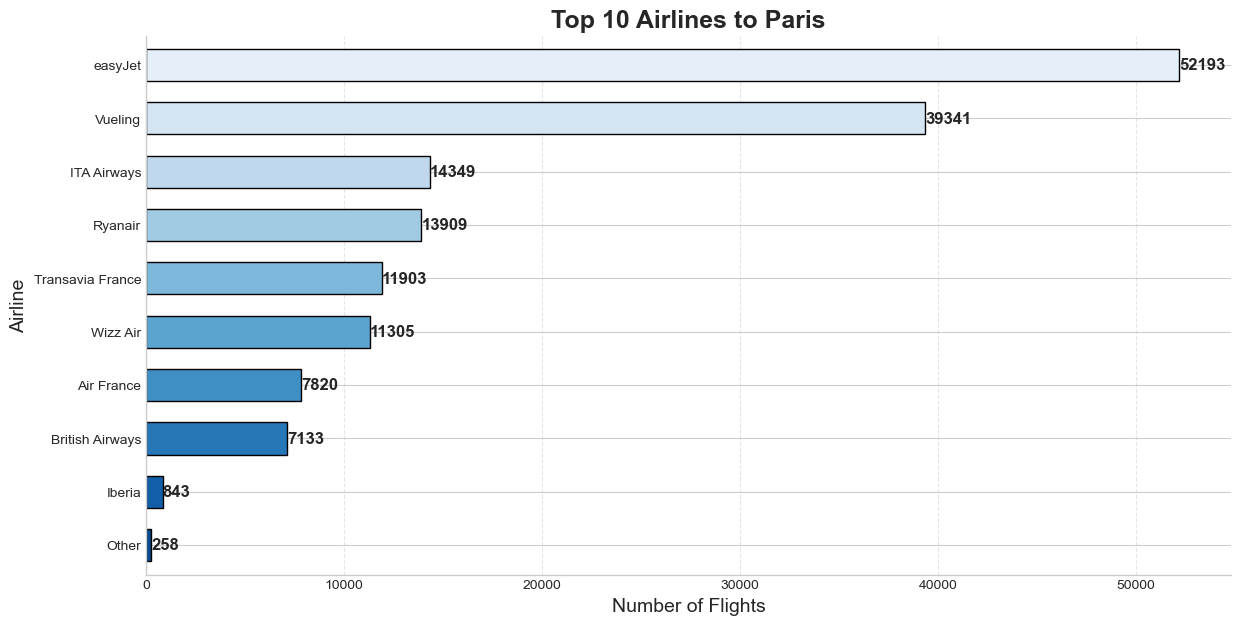

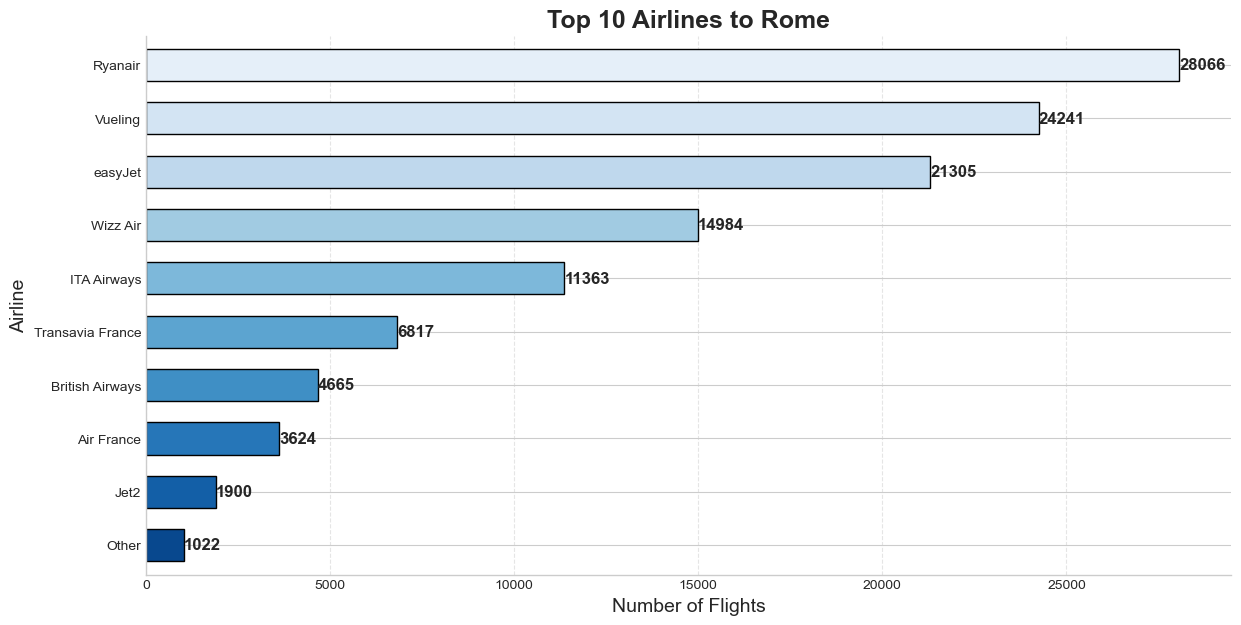

In [122]:
# Set seaborn style for better visualization
sns.set_style("whitegrid")

def top_airlines_per_city(data):
    flight_counts = data.groupby(["destination_city", "to_dest_company"]).size().unstack().fillna(0)

    # Get the top 5 airlines with the most flights for each destination
    london_flights = flight_counts.loc["LONDON"].nlargest(10)
    paris_flights = flight_counts.loc["PARIS"].nlargest(10)
    rome_flights = flight_counts.loc["ROME"].nlargest(10)

    # Plot the results
    flights_counts(london_flights, "London")
    flights_counts(paris_flights, "Paris")
    flights_counts(rome_flights, "Rome")

def flights_counts(dest_flight_counts, dest):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot sorted bar chart
    bars = dest_flight_counts.sort_values(ascending=True).plot(
        kind="barh", 
        ax=ax, 
        edgecolor="black", 
        width=0.6,  # Reduce bar spacing
        color=sns.color_palette("Blues_r", len(dest_flight_counts))
    )

    # Improve aesthetics
    ax.set_title(f"Top 10 Airlines to {dest}", fontsize=18, fontweight="bold")
    ax.set_xlabel("Number of Flights", fontsize=14)
    ax.set_ylabel("Airline", fontsize=14)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add value labels
    for bar in bars.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{int(bar.get_width())}', 
                ha='left', va='center', fontsize=12, fontweight="bold")

    plt.show()

# Call the function
top_airlines_per_city(data)


destination

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning:

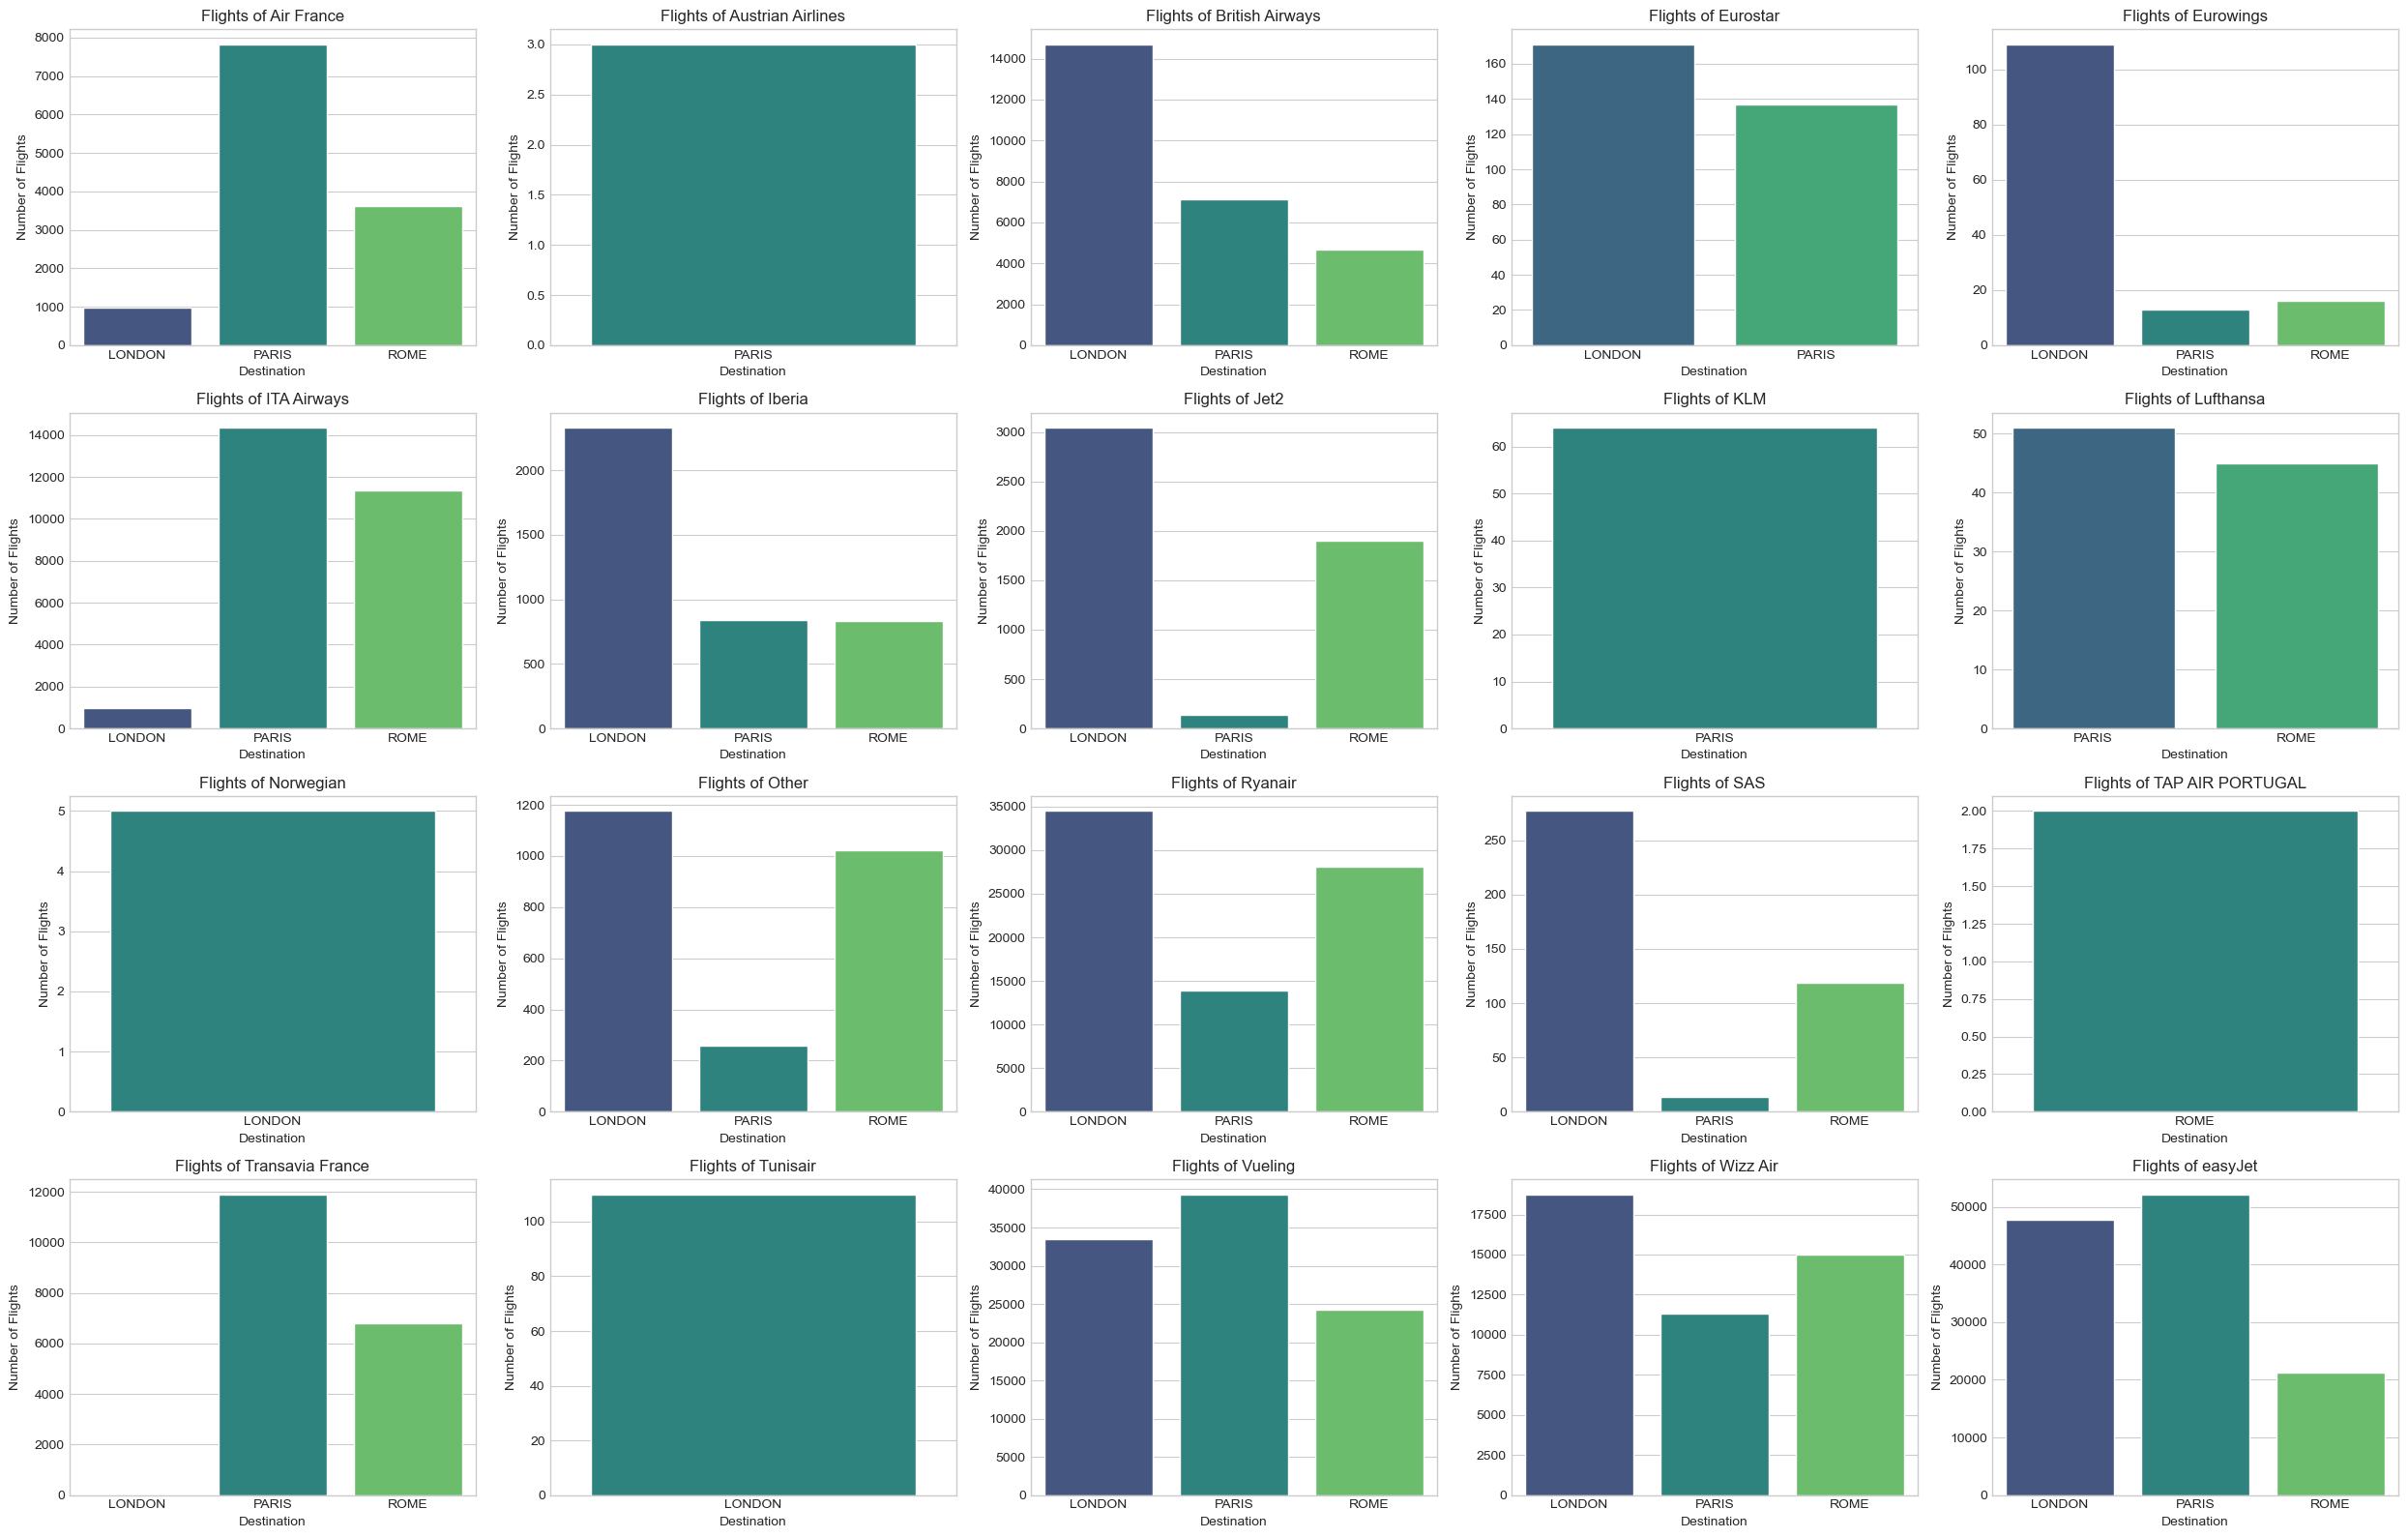

In [123]:
def flights_per_company(data):
    # Group data by flight company and destination, then count flights
    flight_counts = data.groupby(['to_dest_company', 'destination_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['to_dest_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['to_dest_company'] == airline].copy() # Use .loc and .copy()
        # Explicitly group the subset by destination city
        grouped_subset = subset.groupby('destination_city')['count'].sum().reset_index()
        sns.barplot(x='destination_city', y='count', data=grouped_subset, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Destination')
        axes[i].set_ylabel('Number of Flights')

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flights_per_company(data)

origin

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning:

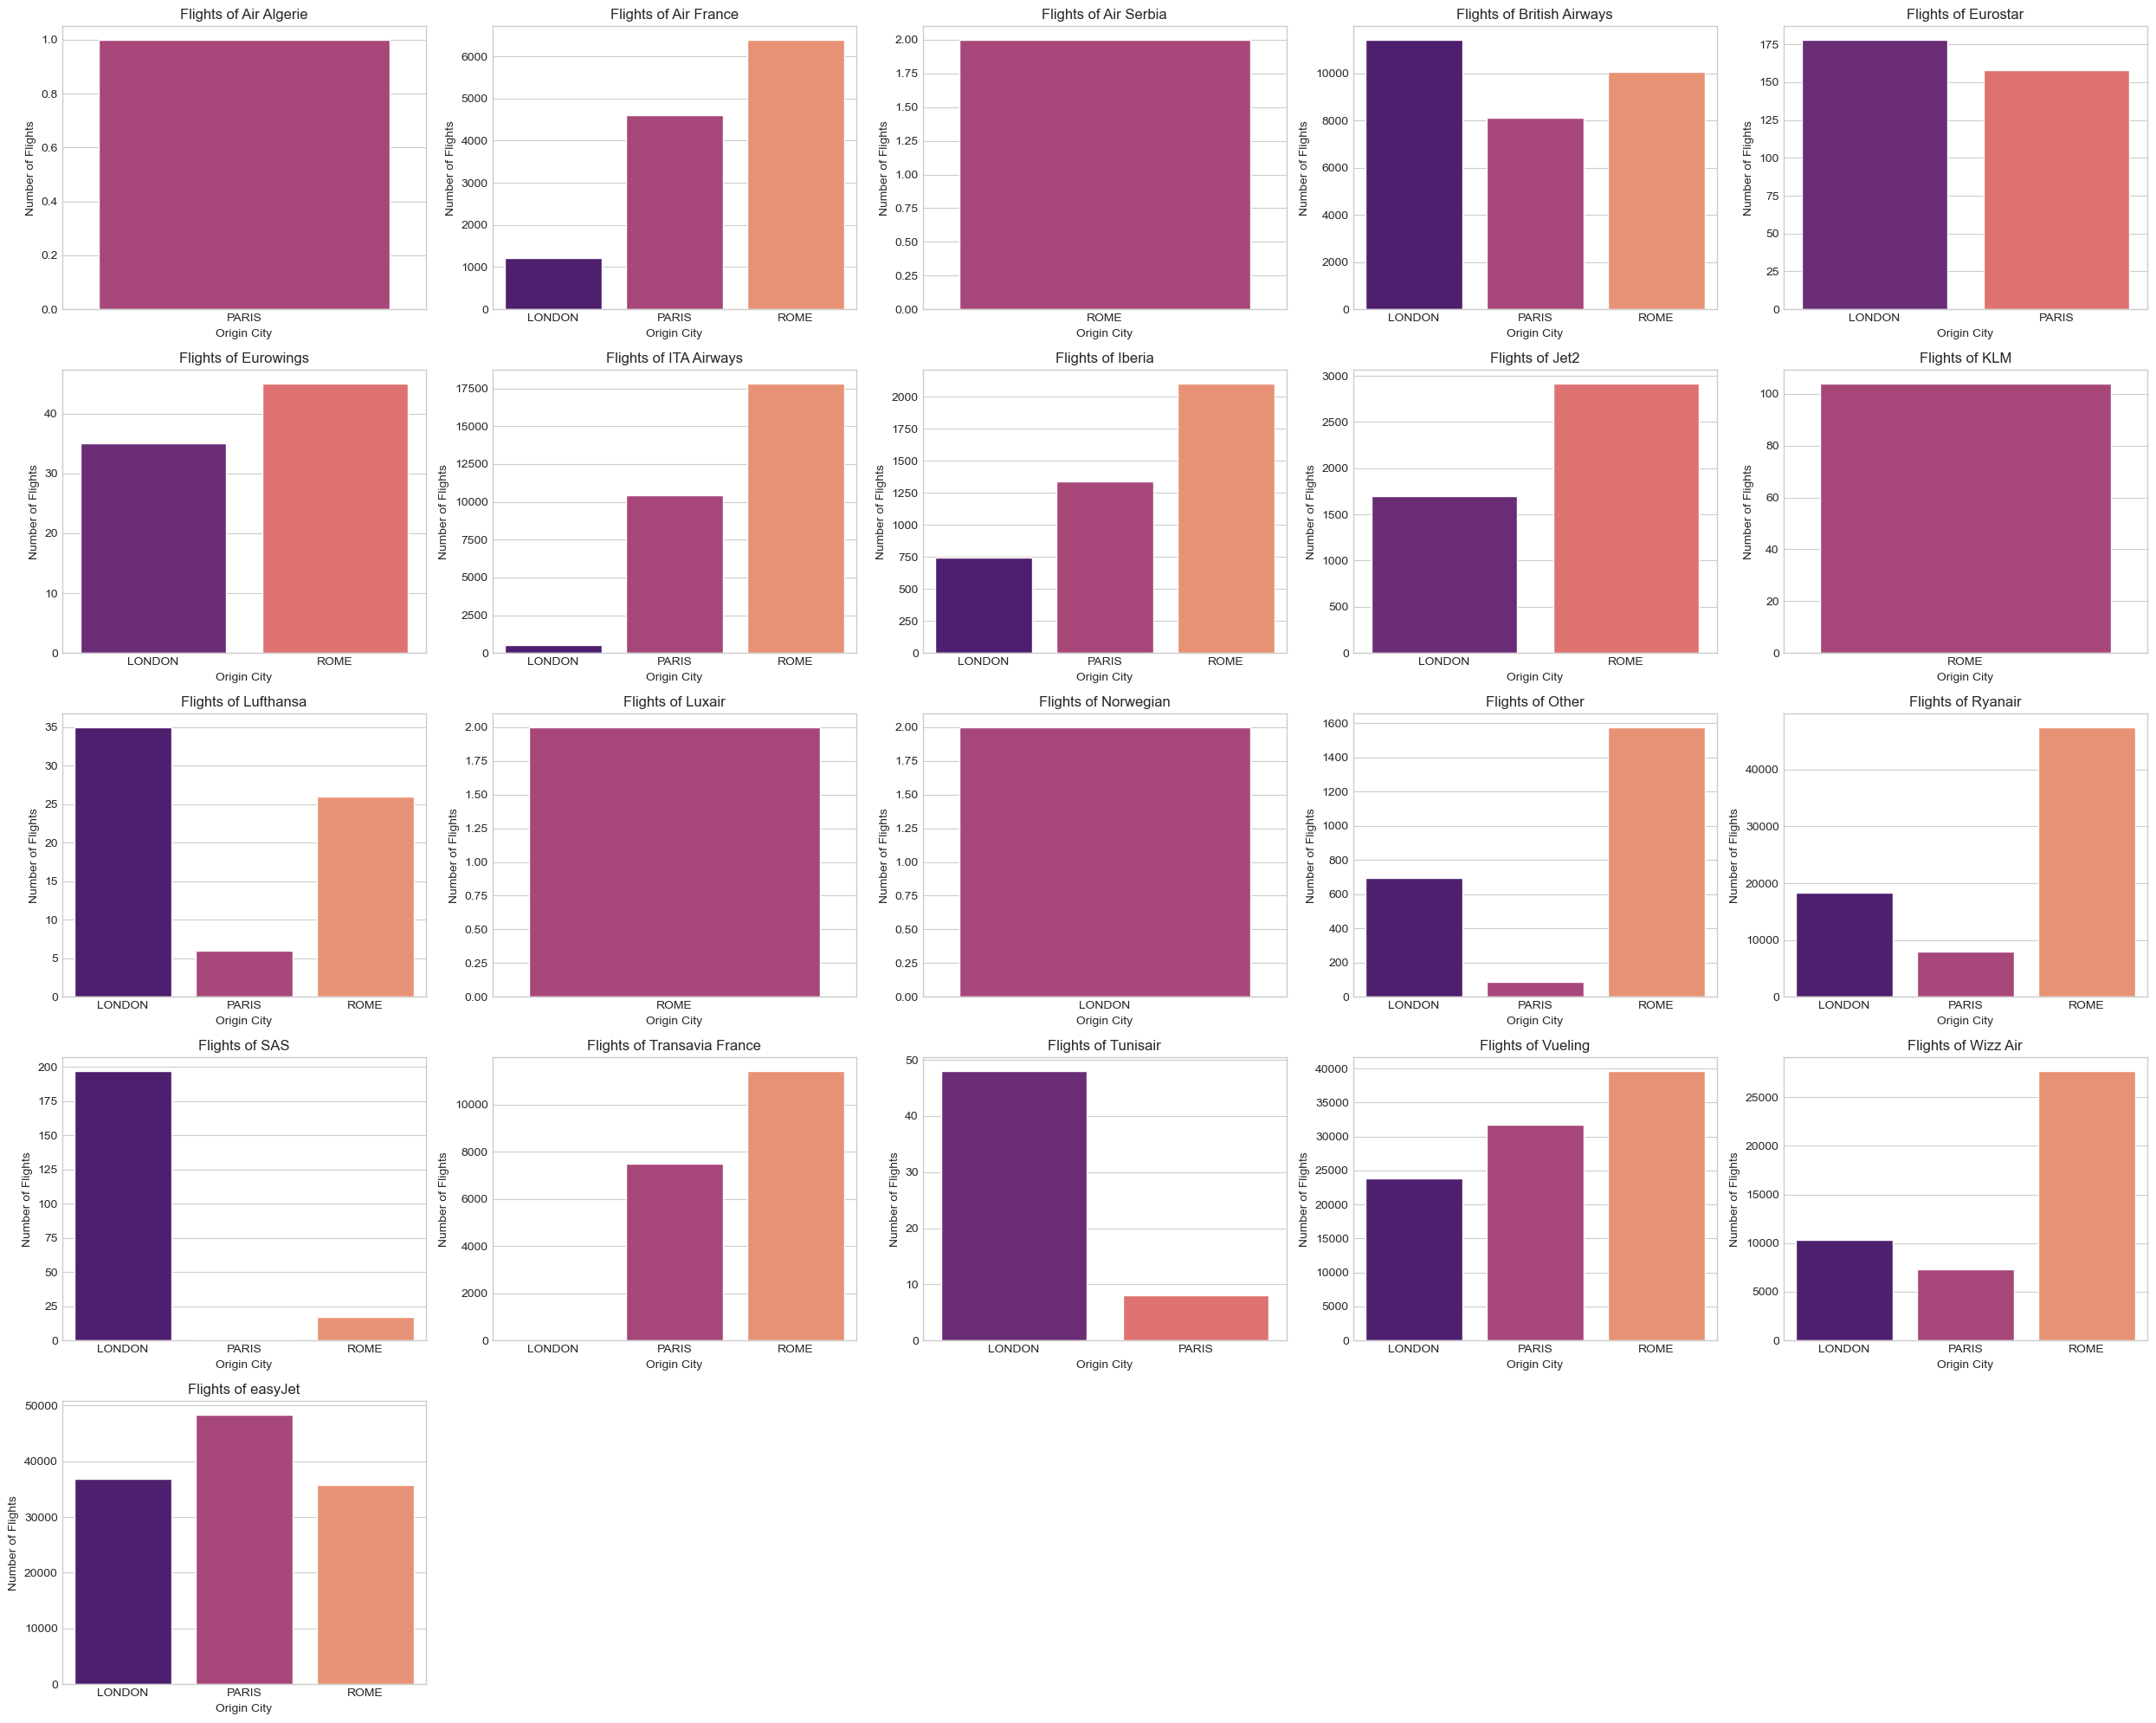

In [124]:
def flight_by_origin_city(data):
    # Group data by flight company and origin city, then count flights
    flight_counts = data.groupby(['return_company', 'origin_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['return_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['return_company'] == airline].copy() # Use .loc and .copy()
        # Explicitly group the subset by origin city
        grouped_subset = subset.groupby('origin_city')['count'].sum().reset_index()
        sns.barplot(x='origin_city', y='count', data=grouped_subset, ax=axes[i], palette='magma')
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Origin City')
        axes[i].set_ylabel('Number of Flights')

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flight_by_origin_city(data)

### Insights
- we can infer that there is a strong corelation between the airway company and the destination city

### Weekdats

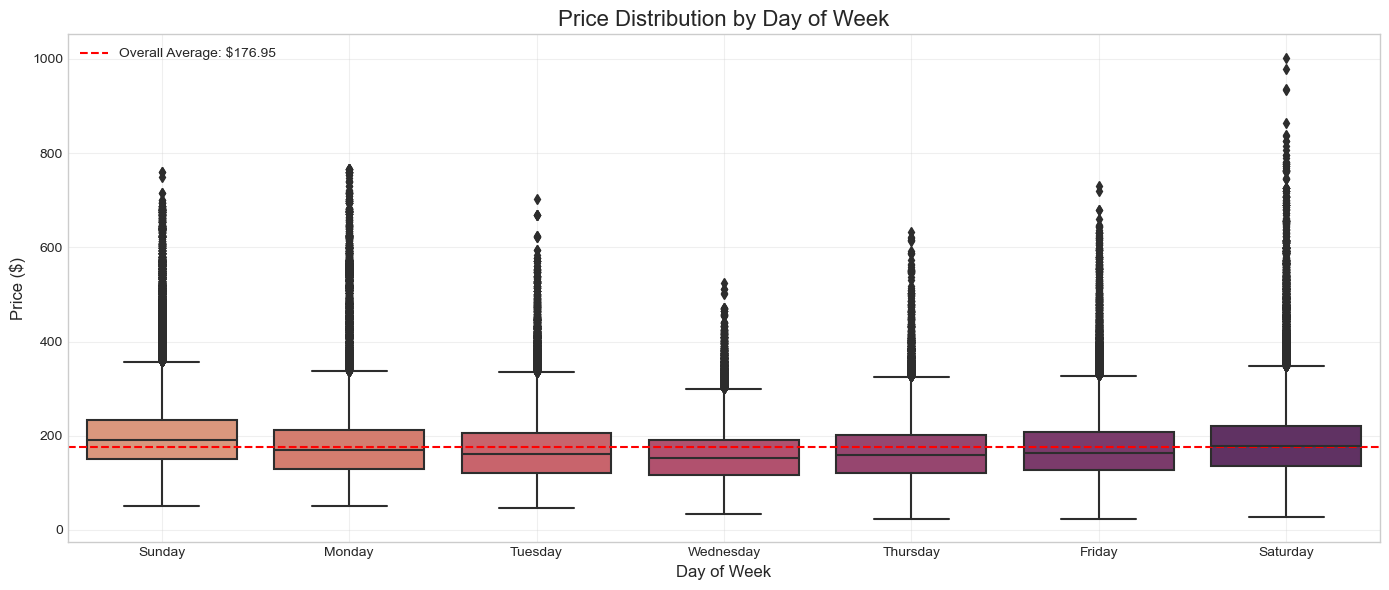

In [125]:
def prices_per_day(data):
    week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        
    fig = plt.figure(figsize=(14, 6))

    sns.boxplot(x='day_of_week', y='price', data=data, order=week_order, palette='flare')
    plt.title('Price Distribution by Day of Week', fontsize=16)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add average line
    plt.axhline(y=data['price'].mean(), color='r', linestyle='--', 
                label=f'Overall Average: ${data["price"].mean():.2f}')
    plt.legend()

    plt.tight_layout()
prices_per_day(data)

### Insights
- on weekend (chrisitan: sunday, saturday) the prices are higher then in the middle of the week (wednesday)
- in saturday the mean is equal to the median and has the largest outlier (prob the most popular so the prices are normlized and has the largest supply)

### Layovers

#### outbound layover

Mean Layover  Median Layover  Min Layover  Max Layover  \
destination_city                                                           
LONDON                  5.3500          0.0000            0         1335   
PARIS                   5.4600          0.0000            0         1495   
ROME                    8.3300          0.0000            0         1245   

                  Layover Std Dev  
destination_city                   
LONDON                    37.1400  
PARIS                     42.5900  
ROME                      45.4800

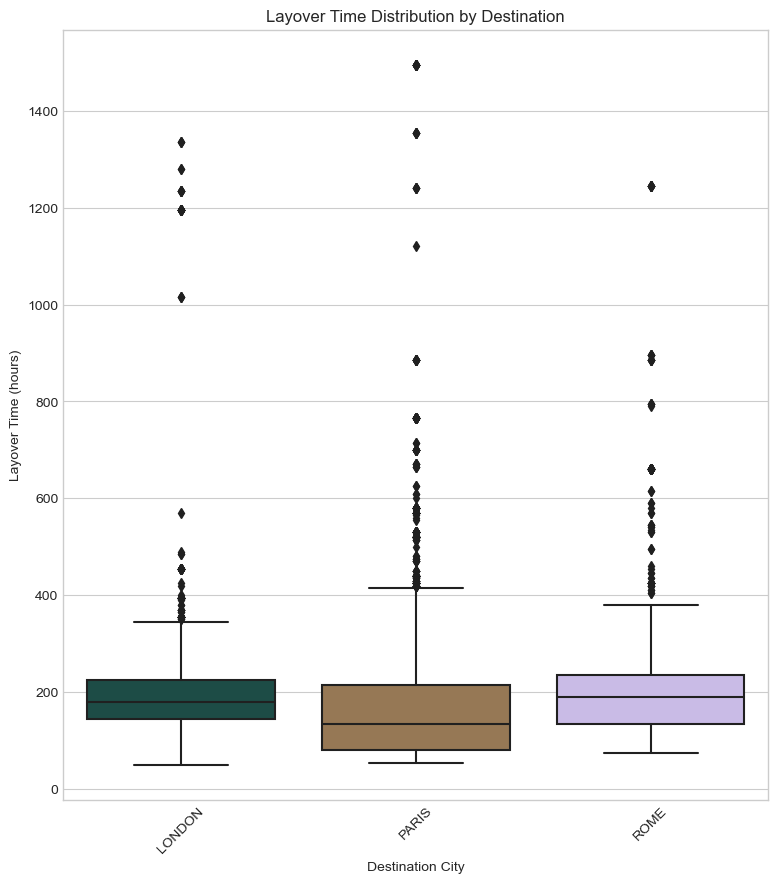

In [126]:
def plot_layover_time(data):
    layover_data = data[data['layover']== True]
    layover_data = layover_data[layover_data['layover_time'] > 0]
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='destination_city', y='layover_time', data=layover_data, palette='cubehelix')
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)

def group_destcity_layovertime(data):
    # Calculate summary statistics
    display(data.groupby('destination_city')['layover_time'].agg([
        ('Mean Layover', 'mean'),
        ('Median Layover', 'median'),
        ('Min Layover', 'min'),
        ('Max Layover', 'max'),
        ('Layover Std Dev', 'std')
    ]).round(2))

def layover_time(data):
    plot_layover_time(data)
    group_destcity_layovertime(data)
    
layover_time(data)

if there is a layover, price dist over time of layover per dest

Mean Layover  Median Layover  Min Layover  Max Layover  \
destination_city                                                           
LONDON                  5.7300          0.0000            0         1245   
PARIS                   4.8200          0.0000            0         1495   
ROME                    6.7700          0.0000            0         1495   

                  Layover Std Dev  
destination_city                   
LONDON                    38.1000  
PARIS                     35.5800  
ROME                      44.0000

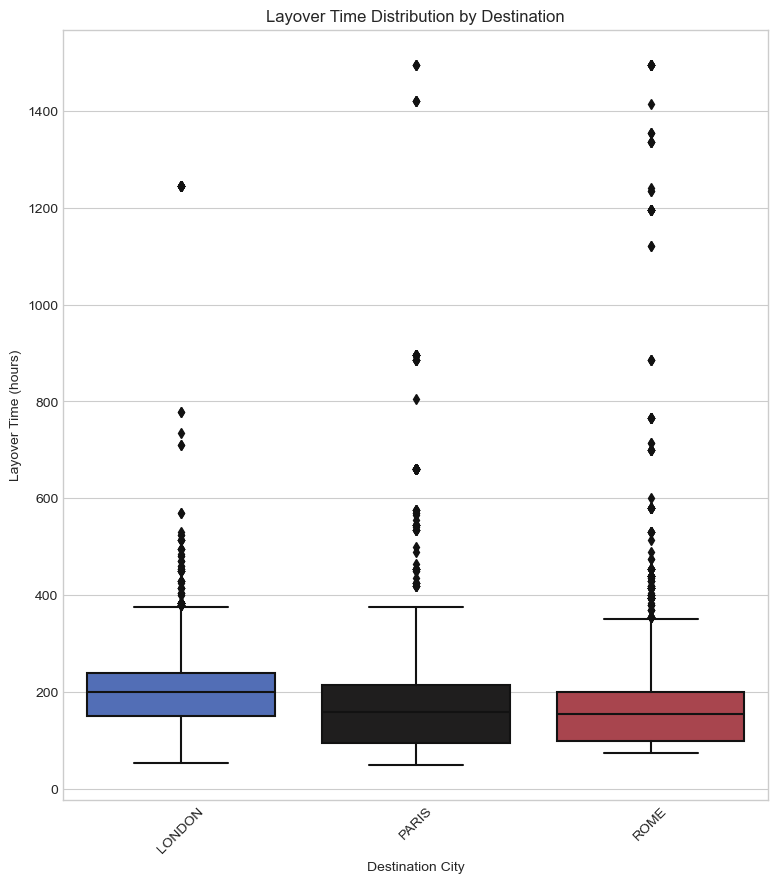

In [127]:
def plot_layover_return_time(data):
    layover_data = data[data['layover']== True]
    layover_data = layover_data[layover_data['return_layover_time'] > 0]
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)


def group_destcity_return_layovertime(data):
    # Calculate summary statistics
    display(data.groupby('destination_city')['return_layover_time'].agg([
        ('Mean Layover', 'mean'),
        ('Median Layover', 'median'),
        ('Min Layover', 'min'),
        ('Max Layover', 'max'),
        ('Layover Std Dev', 'std')
    ]).round(2))

def return_layover_time(data):
    plot_layover_return_time(data)
    group_destcity_return_layovertime(data)
    
return_layover_time(data)

departure airport per city price influance

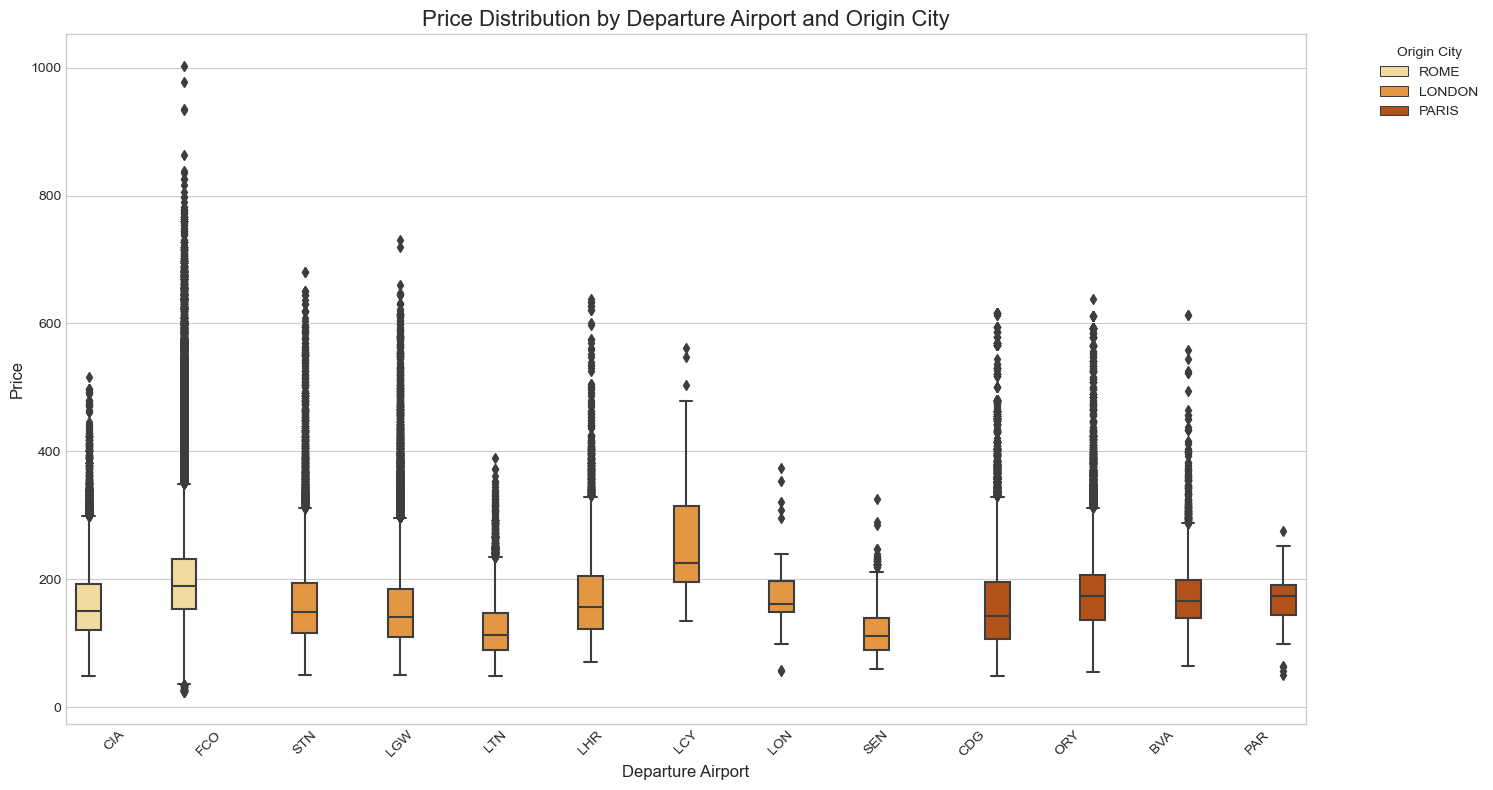

In [128]:
def price_per_deptair_origcity(data):
    plt.figure(figsize=(15, 8))
        
    # Create a box plot to show price distribution by departure airport for each origin city
    sns.boxplot(x='departure_airport', y='price', hue='origin_city', data=data ,palette='YlOrBr')

    plt.title('Price Distribution by Departure Airport and Origin City', fontsize=16)
    plt.xlabel('Departure Airport', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Origin City', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

def group_origincity_deptairport(data):
    # Calculate summary statistics
    data.groupby(['origin_city', 'departure_airport'])['price'].agg([
        ('Mean Price', 'mean'),
        ('Median Price', 'median'),
        ('Min Price', 'min'),
        ('Max Price', 'max'),
        ('Price Std Dev', 'std'),
        ('Number of Flights', 'count')
    ]).round(2)

price_per_deptair_origcity(data)
group_origincity_deptairport(data)

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


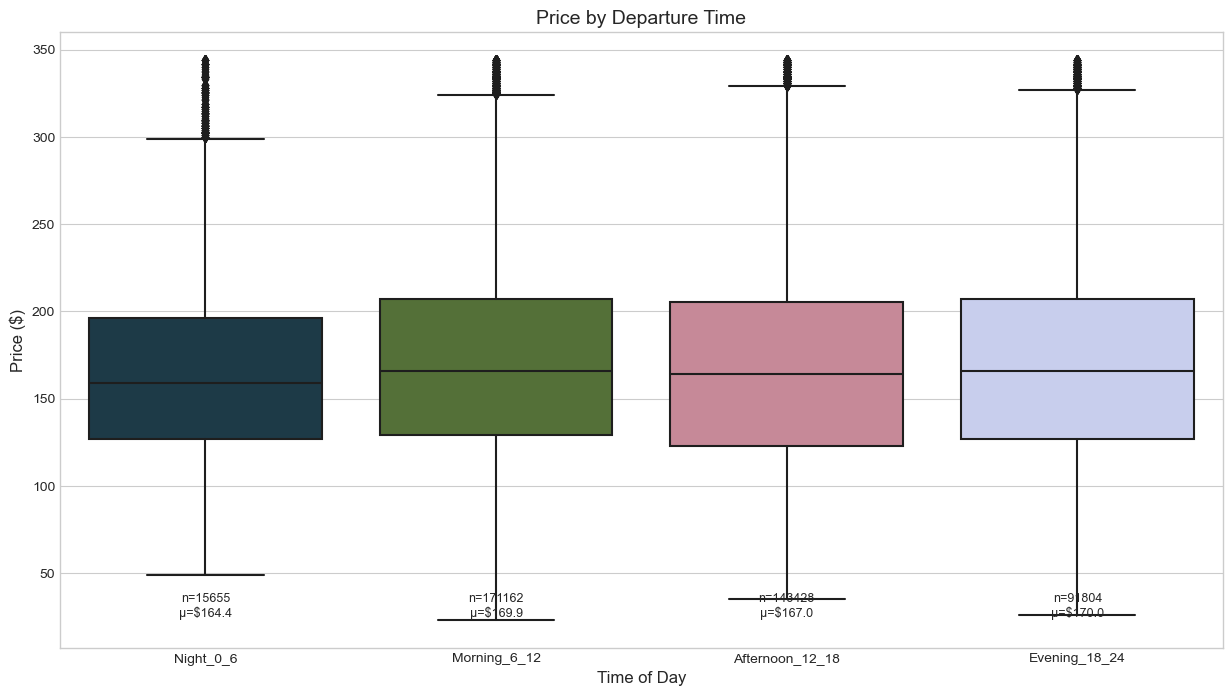

In [176]:
plt.figure(figsize=(15, 8))

# Create time categories
data['time_category'] = pd.cut(
    data['departure_hour'], 
    bins=[0, 6, 12, 18, 24],
    labels=['Night_0_6', 'Morning_6_12', 'Afternoon_12_18', 'Evening_18_24']
)

sns.boxplot(x='time_category', y='price', data=data, palette='cubehelix')
plt.title('Price by Departure Time', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Add count and mean annotations
for i, category in enumerate(data['time_category'].cat.categories):
    count = data[data['time_category'] == category].shape[0]
    mean = data[data['time_category'] == category]['price'].mean()
    plt.annotate(f'n={count}\nμ=${mean:.1f}', 
                        xy=(i, data['price'].min()), 
                        ha='center', va='bottom', fontsize=9)

evening and afternoon almost identical

### Remove the outlier (Tukey method: 1.5*IQR)

In [15]:
def remove_route_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group['price'] >= lower_bound) & 
                        (group['price'] <= upper_bound)]

#### Lets visualize before and after removing the outlier (price over route)

C:\Users\Nadav\AppData\Local\Temp\ipykernel_17060\2674912080.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)


Original DataFrame size: 436873
Cleaned DataFrame size: 422049
Number of outliers removed: 14824
Percentage of data removed: 3.39%

Price Statistics - Original Data:
              Mean Price  Median Price  Min Price  Max Price  Price Std Dev  \
route                                                                         
LONDON_PARIS      129.95        122.00       48.0      414.0          46.90   
LONDON_ROME       177.38        161.00       50.0      730.0          74.78   
PARIS_LONDON      126.42        122.74       48.0      326.0          38.53   
PARIS_ROME        204.12        197.00       63.0      639.0          54.40   
ROME_LONDON       172.94        160.59       23.0      592.0          66.19   
ROME_PARIS        216.48        199.00       57.0     1003.0          82.38   

              Total Flights  
route                        
LONDON_PARIS          54515  
LONDON_ROME           51640  
PARIS_LONDON          60316  
PARIS_ROME            67360  
ROME_LONDON          

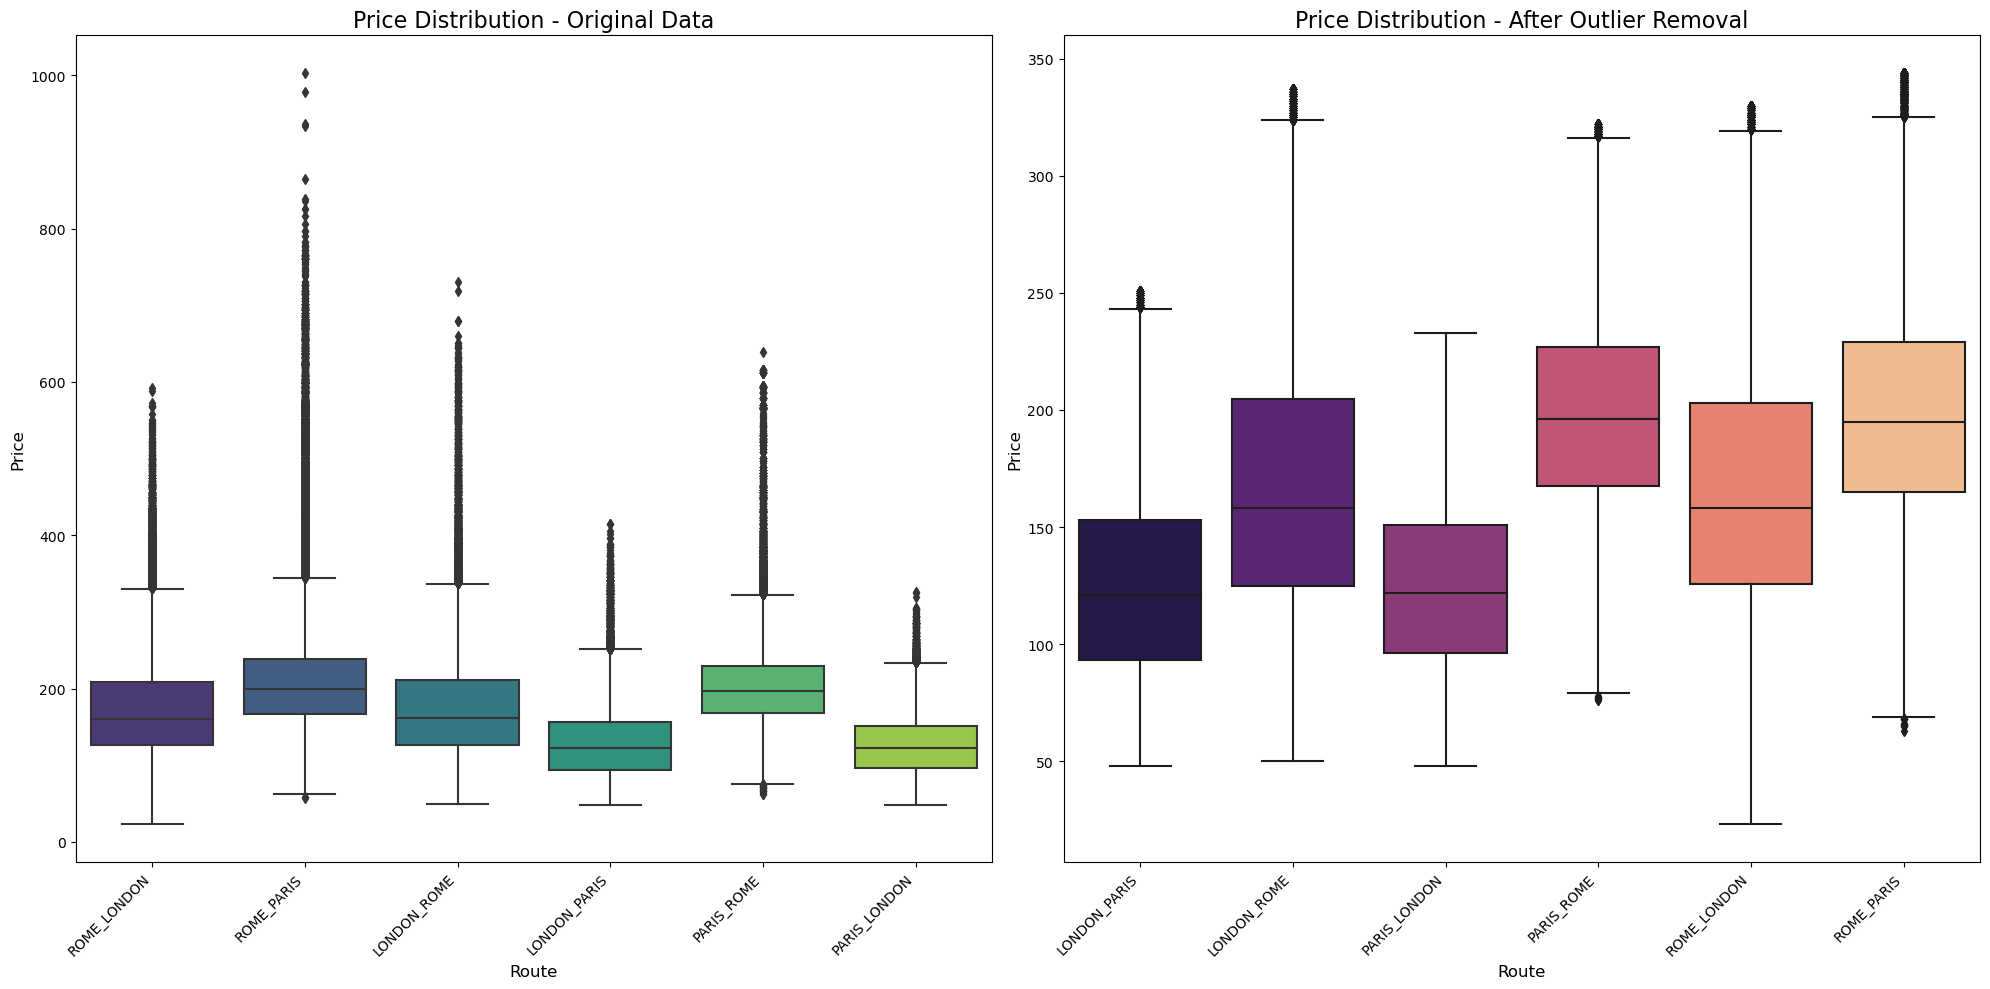

In [16]:
# Group by route and remove outliers
data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)

# Print removal statistics
original_count = len(data)
cleaned_count = len(data_cleaned)
removed_count = original_count - cleaned_count

print(f"Original DataFrame size: {original_count}")
print(f"Cleaned DataFrame size: {cleaned_count}")
print(f"Number of outliers removed: {removed_count}")
print(f"Percentage of data removed: {removed_count/original_count*100:.2f}%")

# Set up the figure with two subplots
plt.figure(figsize=(20, 10))

# Original Data Distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='route', y='price', data=data, palette='viridis')
plt.title('Price Distribution - Original Data', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Cleaned Data Distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')
plt.title('Price Distribution - After Outlier Removal', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust layout and save
plt.tight_layout()

# Additional statistical summary
print("\nPrice Statistics - Original Data:")
original_stats = data.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(original_stats)

print("\nPrice Statistics - Cleaned Data:")
cleaned_stats = data_cleaned.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(cleaned_stats)
data = data_cleaned

### Pairplot

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 2000x1600 with 0 Axes>

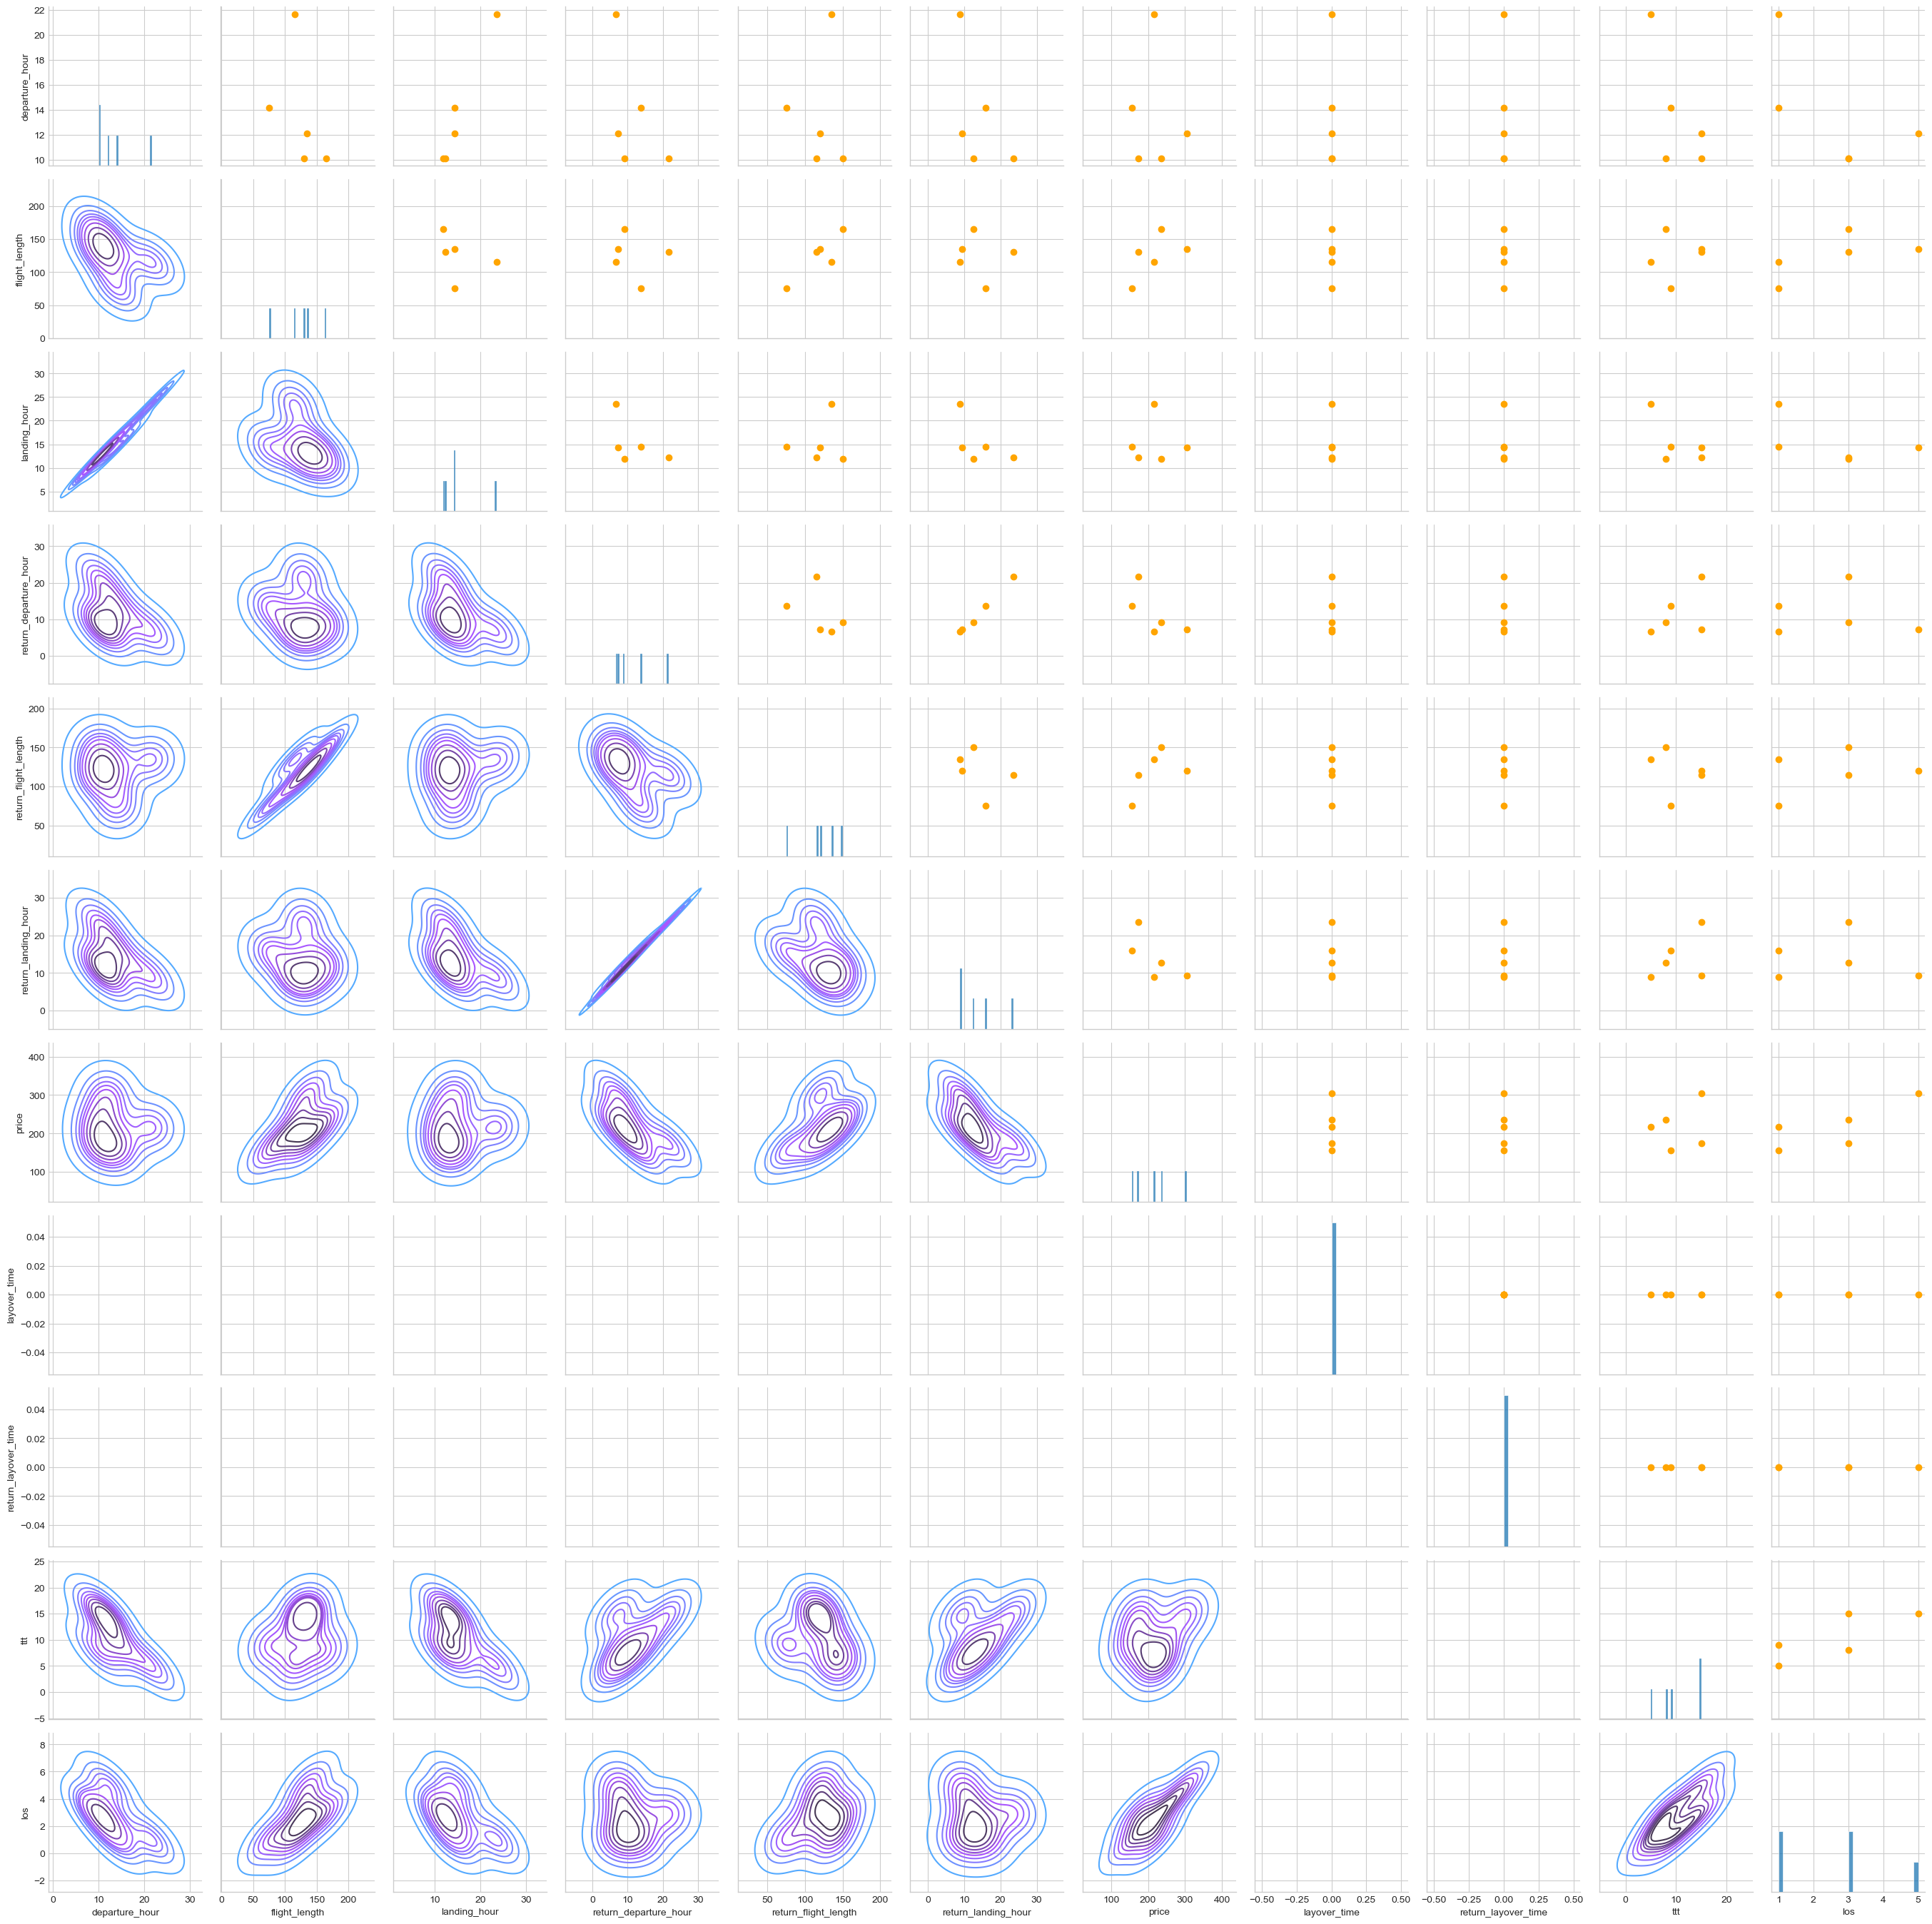

In [132]:
plt.figure(figsize=(20.0,16))
numeric_cols = ['departure_hour', 'flight_length', 'landing_hour', 
                'return_departure_hour', 'return_flight_length', 
                'return_landing_hour', 'price', 'layover_time', 
                'return_layover_time', 'ttt', 'los']
sampled_data = data_cleaned.sample(5, random_state=random_state)
pair_grid = sns.PairGrid(sampled_data[numeric_cols])
pair_grid.map_upper(plt.scatter,color='orange')
pair_grid.map_lower(sns.kdeplot,cmap='cool_d')
pair_grid.map_diag(sns.histplot,bins=30)
pair_grid.savefig('pairplot.png')

theres is a strong corolation between the layover time and the flight time (outbound and return)
also between the price and the flight lenght (flight lenght is the total lenght of the outbount flight incloude layover time, the same for return_flight_lenght)

<Axes: >

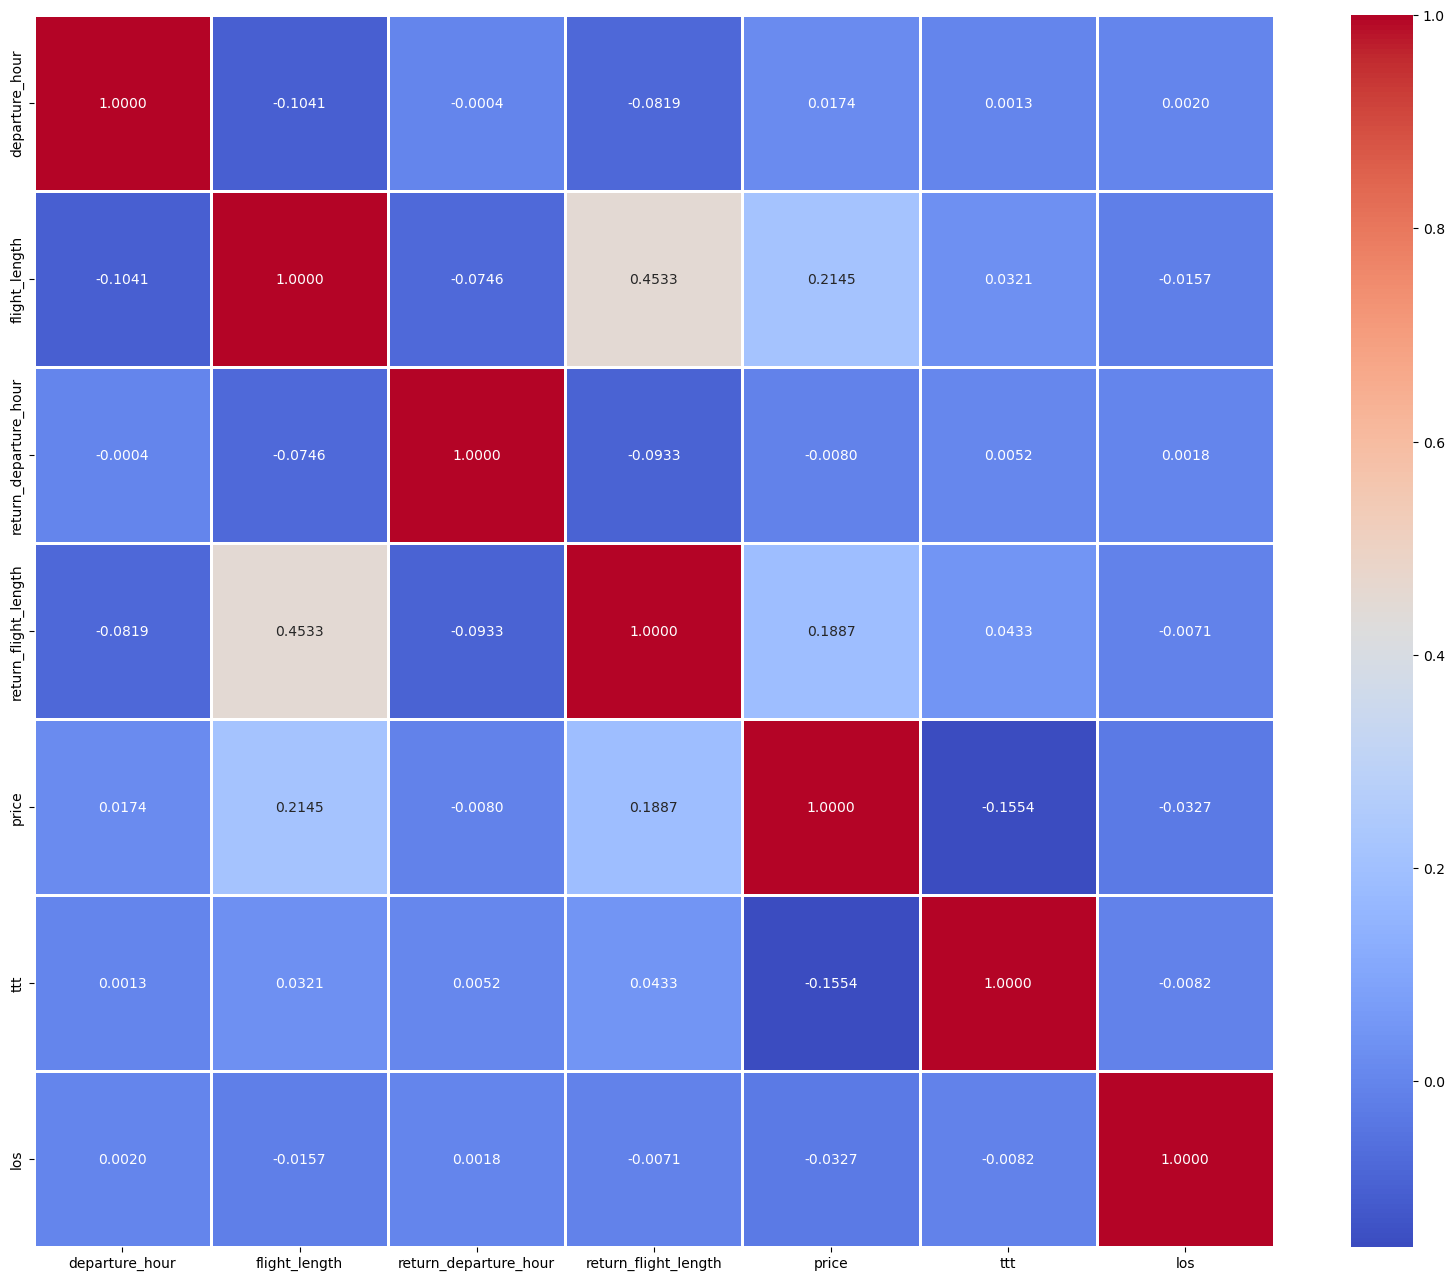

In [17]:
numeric_cols_refactored = ['departure_hour', 'flight_length', 'return_departure_hour', 'return_flight_length', 'price', 'ttt', 'los']
plt.figure(figsize=(20.0,16))
sns.heatmap(data[numeric_cols_refactored].corr(),annot=True,cmap='coolwarm',fmt='.4f',linewidths=2)

we can exclude the corr(return_flight_lenght,flight_lenght) because its the same distance (round trip), with domain knowlage we can tell that the corr is not 1 becase the Centrifugal force of earth spining makes one way shorter then the other.

### Insights:
- the flight lenghts will have the strongest corr with the price.
- ttt also has influance on the price
- the los influance on the price is very low

## Stage 5: Evaluation and baseline creation

#### lets split to train and test data

In [147]:
sample = data.sample(500, random_state=random_state)
y = sample.price
X = sample.drop(["price"], axis=1)

# define numerical features
numerical_features = X.select_dtypes(include='number').columns

## Processing Data for baseline
We need to convert the type of all the object in the dataset to category, as object sometimes can cause error when running models (because it is not recognizable). 
</br>
In addition we need to address the Encoding of categorical features and the standardization/normalization of the data

In [148]:
def convert_object_to_category(df):
    for feature in df.select_dtypes(include='object').columns:
        df[feature] = df[feature].astype('category')

### Categorical Encoding
From looking at the categorical features in the dataframe we can infer that the relevant categorical methods may be the following 
<ul>
    <li>OneHotEncoding (get_dummies) - probably the most robust option</li>
    <li>TargetEncoder - might be sensitive to overfitting if used incorrectly</li>
    <li>HashingEncoder</li>
    <li>CountEncoder</li>
</ul>

In [149]:
def categorical_encoding(X, encoding_type='onehot', y = None, hash_n_features=8):

    categorical_cols = X.select_dtypes(include='category').columns

    if encoding_type == 'onehot':
        X = pd.get_dummies(X, columns=categorical_cols)

    # Note target encoding is sensitive to overfitting
    elif encoding_type == 'target':
        if y:
            encoder = TargetEncoder(cols=categorical_cols)
            X = encoder.fit_transform(X, y)
        else:
            raise ValueError("target_column must be provided for target encoding.")

    elif encoding_type == 'hash':
        encoder = HashingEncoder(cols=categorical_cols, n_features=hash_n_features)
        X = encoder.fit_transform(X)

    elif encoding_type == 'count':
        encoder = CountEncoder(cols=categorical_cols)
        X = encoder.fit_transform(X)

    return X

### Normalization / Standartization

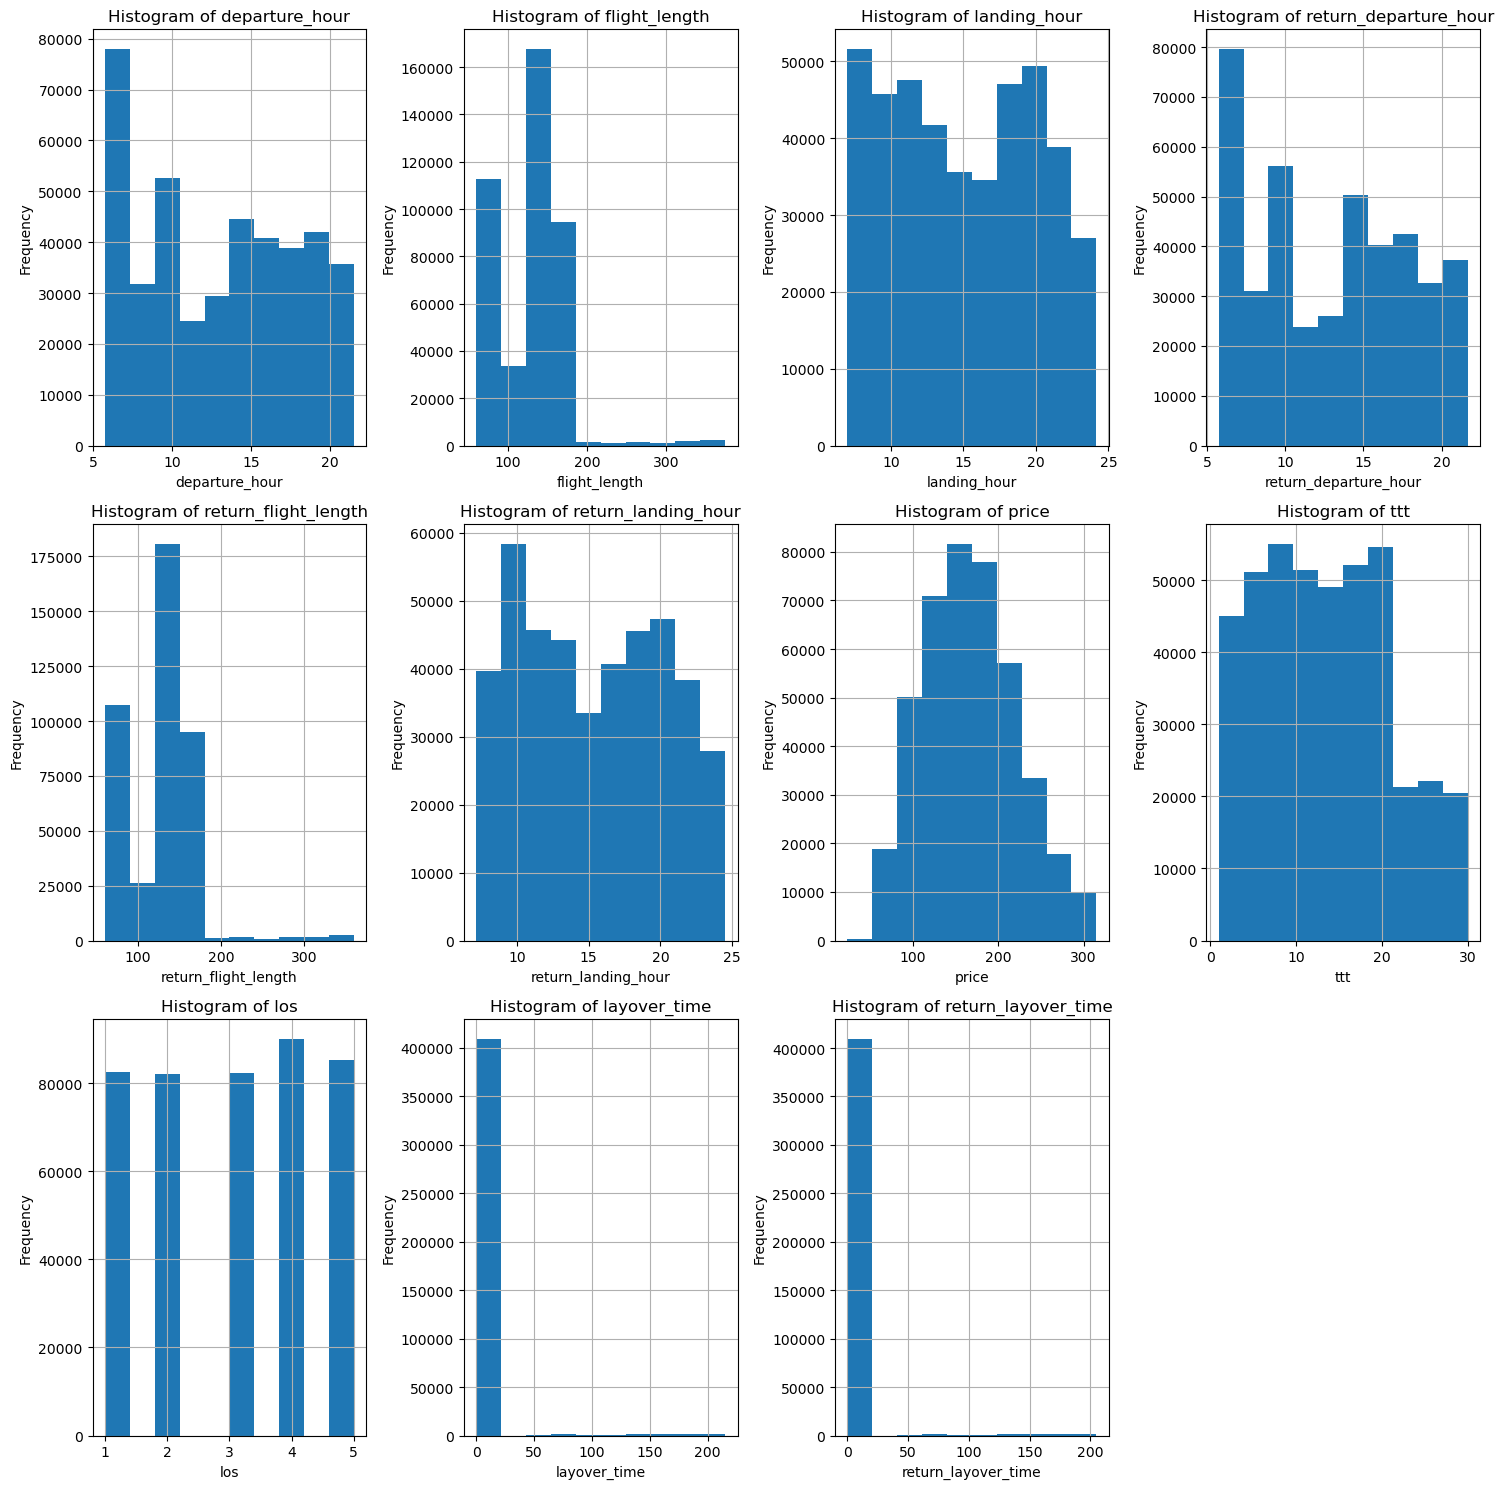

In [150]:
def histogram_new_features(df, rows):
    """
    Plots histograms for all numeric columns in the DataFrame 

    Args:
    df: The input DataFrame.
    rows: The number of rows in the grid layout.
    """
    df_cols = df.columns
    percentiles = df.quantile(0.99)
    
    cols_per_row = math.ceil(len(df_cols) / rows)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5*rows))
    
    # Ensure axes is always 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols_per_row == 1:
        axes = axes.reshape(-1, 1)

    for i, col in enumerate(df_cols):
        row, col_idx = i // cols_per_row, i % cols_per_row
        
        filtered_data = df[col][df[col] <= percentiles[col]]
        ax = axes[row, col_idx]
        filtered_data.hist(ax=ax)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

    # Hide any unused subplots
    for i in range(len(df_cols), rows * cols_per_row):
        row, col_idx = i // cols_per_row, i % cols_per_row
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
num_columns = data.select_dtypes(include='number').columns.tolist()
histogram_new_features(data[num_columns], rows=3)

Results - The price is normally distributed. All of the other features does not follow guassian distribution.

In [151]:
def normalize_numerical_features(train, test, numerical_columns, method='minmax'):

    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()

    train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
    test[numerical_columns] = scaler.transform(test[numerical_columns])
    return train, test

In [152]:
# Conver dtype to string
X["departure_date"] = X["departure_date"].astype(str)

convert_object_to_category(X)
X = categorical_encoding(X)

# Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Normalize using Min-Max scaling (default)
X_minmax, X_test_minmax = normalize_numerical_features(X.copy(), X_test.copy(), numerical_features)
print("Min-Max Scaled:\n", X_minmax)

# Normalize using Standardization
X_standard, X_test_standard = normalize_numerical_features(X.copy(), X_test.copy(), numerical_features, method='standard')
print("\nStandard Scaled:\n", X_standard)

# Normalize using Robust Scaling
X_robust, X_test_robust = normalize_numerical_features(X.copy(), X_test.copy(), numerical_features, method='robust')
print("\nRobust Scaled:\n", X_robust)

Min-Max Scaled:
         departure_hour  flight_length  landing_hour  return_departure_hour  \
13781           0.5156         0.0303        0.5288                 0.0739   
134950          0.7656         0.0303        0.6442                 0.8177   
193093          0.2500         0.1212        0.2692                 0.8424   
156985          0.0833         0.0404        0.0192                 0.4778   
227756          0.6719         0.1010        0.6490                 0.8621   
...                ...            ...           ...                    ...   
79358           0.9427         0.1515        0.9808                 0.9064   
58393           0.0312         0.1616        0.1442                 0.8325   
242369          0.0156         0.6263        0.2356                 0.2956   
182810          0.7969         0.5960        1.0000                 0.0542   
80641           0.0625         0.1717        0.1779                 0.3744   

        return_flight_length  return_landing_h

In [153]:
# Create rmse loss function
def custom_rmse(y_true, y_pred):
    return abs(np.sqrt(mean_squared_error(y_true, y_pred)))

def evaluate_models(train, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    models = [
        CatBoostRegressor(verbose=False),
        LGBMRegressor(verbose=-1),
        XGBRegressor(),
        RandomForestRegressor(),
        LinearRegression(),
        DecisionTreeRegressor(),
        GaussianProcessRegressor()
    ]

    models_names = [
        "CatBoostRegressor",
        "LGBMRegressor",
        "XGBRegressor",
        "RandomForestRegressor",
        "LinearRegression",
        "DecisionTreeRegressor",
        "GaussianProcessRegressor"
    ]

    # Define scoring metrics
    scoring_metrics = {
        "MSE": make_scorer(mean_squared_error),
        "RMSE": make_scorer(custom_rmse, greater_is_better=False),
        "MAE": make_scorer(mean_absolute_error),
        "R2": make_scorer(r2_score)
    }

    results = {metric: [] for metric in scoring_metrics.keys()}

    for model in models:
        for metric, scorer in scoring_metrics.items():
            scores = cross_val_score(model, train, y, scoring=scorer, cv=cv, n_jobs=-1)
            results[metric].append(scores.mean())

    # Create DataFrame
    cv_res = pd.DataFrame(results)
    cv_res["Algorithm"] = models_names

    pd.options.display.float_format = '{:.4f}'.format

    return cv_res

In [154]:
def evalution_func(X, y):

    start_time = time.time()

    display(evaluate_models(X, y))

    end_time = time.time()

    elapsed_time = end_time - start_time
    print("Evaluation time:", elapsed_time, "seconds")

In [192]:
print("Baseline models evaluation - only numerical features")

# Evaluate models Only numeric
X_numeric = X.select_dtypes(include='number')
evalution_func(X_numeric, y) 

Baseline models evaluation - only numerical features


MSE      RMSE      MAE      R2                 Algorithm
0  2542.6403  -50.3768  38.4041  0.2522         CatBoostRegressor
1  2636.0356  -51.2817  39.3206  0.2210             LGBMRegressor
2  2743.9671  -52.2107  39.3554  0.1853              XGBRegressor
3  2225.0469  -47.8436  36.7927  0.3349     RandomForestRegressor
4  3102.1292  -55.6579  44.8341  0.0993          LinearRegression
5  3975.9918  -63.2612  48.1584 -0.1969     DecisionTreeRegressor
6 31357.6715 -176.8152 166.1611 -8.0638  GaussianProcessRegressor

Evaluation time: 20.48303723335266 seconds


In [156]:
print("Baseline models evaluation - onehot encoding")

evalution_func(X,y)

Baseline models evaluation - onehot encoding


MSE             RMSE            MAE  \
0                 1785.3419         -42.0101        31.8296   
1                 2206.8575         -46.8222        36.4577   
2                 2065.1362         -45.1253        34.6501   
3                 1894.2618         -43.9310        33.6008   
4 50987079304985427968.0000 -3310873621.8924 511522831.2625   
5                 3043.1693         -56.3438        42.2537   
6                32195.4847        -179.2080       169.2133   

                       R2                 Algorithm  
0                  0.4714         CatBoostRegressor  
1                  0.3428             LGBMRegressor  
2                  0.3855              XGBRegressor  
3                  0.4301     RandomForestRegressor  
4 -17859975112257100.0000          LinearRegression  
5                  0.0346     DecisionTreeRegressor  
6                 -8.3174  GaussianProcessRegressor

Evaluation time: 32.73074746131897 seconds


In [157]:
# Trying various normalization techniques to see which one works best
print("Test differnet normalization techniques\n")

print("Baseline models evaluation -  minmax scaling")
evalution_func(X_minmax,y)

print("Baseline models evaluation -  standard scaling")
evalution_func(X_standard,y)

print("Baseline models evaluation -  robust scaling")  
evalution_func(X_robust,y)

Test differnet normalization techniques

Baseline models evaluation -  minmax scaling


MSE                 RMSE                MAE  \
0                         1783.5115             -41.9857            31.8151   
1                         2206.6877             -46.8201            36.4530   
2                         2065.1362             -45.1253            34.6501   
3                         1886.9551             -43.6030            33.5968   
4 6645668898411766390911401984.0000 -52992316589180.2812 7445585432875.7363   
5                         3152.7422             -55.3810            41.1476   
6                        25046.4900            -157.9856           147.3339   

                               R2                 Algorithm  
0                          0.4719         CatBoostRegressor  
1                          0.3428             LGBMRegressor  
2                          0.3855              XGBRegressor  
3                          0.4591     RandomForestRegressor  
4 -1608947554193249478377472.0000          LinearRegression  
5                          0.0729     DecisionTreeRegressor  
6                         -6.2372  GaussianProcessRegressor

Evaluation time: 64.76124095916748 seconds
Baseline models evaluation -  standard scaling


MSE                RMSE               MAE  \
0                      1784.9303            -42.0034           31.8405   
1                      2212.1855            -46.8671           36.4274   
2                      2065.1362            -45.1253           34.6501   
3                      1905.1892            -43.4642           33.4407   
4 9756363561857814301245440.0000 -2440997258776.9614 334064036072.4064   
5                      3122.7389            -56.1621           41.7280   
6                     31099.1984           -176.1233          166.1809   

                            R2                 Algorithm  
0                       0.4715         CatBoostRegressor  
1                       0.3411             LGBMRegressor  
2                       0.3855              XGBRegressor  
3                       0.4350     RandomForestRegressor  
4 -2933717799724924796928.0000          LinearRegression  
5                       0.0511     DecisionTreeRegressor  
6                      -8.0014  GaussianProcessRegressor

Evaluation time: 66.11168670654297 seconds
Baseline models evaluation -  robust scaling


MSE      RMSE      MAE      R2                 Algorithm
0  1783.6391  -41.9872  31.8220  0.4719         CatBoostRegressor
1  2207.1290  -46.8254  36.4602  0.3427             LGBMRegressor
2  2065.1362  -45.1253  34.6501  0.3855              XGBRegressor
3  1866.6145  -43.5271  33.9701  0.4214     RandomForestRegressor
4  2954.8952  -53.9875  39.8750  0.1098          LinearRegression
5  3300.5781  -56.6480  41.6065  0.0405     DecisionTreeRegressor
6 29237.5099 -170.7505 160.5785 -7.4604  GaussianProcessRegressor

Evaluation time: 39.69536256790161 seconds


Insights - It's seems as though there is almost no difference between the different normalization techniques. In addition, it can be seen that they also don't provide an advantage relative to the baseline without normalization (both by score and run time) 

<h3>Feature Engineering</h3>
After We created the baseline 

### Hyperparameters Tuning
An important part of the data science project structure is Hyperparameters Tuning which involves on tuning the parameters each model have using various techniques. 
We decided to use the library optuna, as it usually provides robust solution and it inclined to find good results

In [158]:
def objective_catboost(trial, X_train, y_train):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'random_strength': trial.suggest_uniform('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
    }

    model = CatBoostRegressor(**params, verbose=0, early_stopping_rounds=50)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))  # Optuna tries to minimize, so we negate RMSE


# XGBoost
def objective_xgboost(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
    }

    model = XGBRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))


# LightGBM
def objective_lightgbm(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    }

    model = LGBMRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))


# RandomForest
def objective_randomforest(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = RandomForestRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))


# DecisionTreeRegressor
def objective_decisiontree(trial, X_train, y_train):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = DecisionTreeRegressor(**params, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))

# GaussianProcessRegressor
def objective_gaussianprocess(trial, X_train, y_train):
    kernel_type = trial.suggest_categorical('kernel', ['RBF', 'Matern', 'RationalQuadratic'])
    length_scale = trial.suggest_loguniform('length_scale', 1e-1, 1e2)

    if kernel_type == 'RBF':
        kernel = RBF(length_scale=length_scale)
    elif kernel_type == 'Matern':
        nu = trial.suggest_categorical('nu', [0.5, 1.5, 2.5])
        kernel = Matern(length_scale=length_scale, nu=nu)
    elif kernel_type == 'RationalQuadratic':
        alpha = trial.suggest_loguniform('alpha', 1e-1, 1e2)
        kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha)

    model = GaussianProcessRegressor(kernel=kernel, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))

# LinearRegression (no hyperparameters to tune)
def objective_lr(trial, X_train, y_train):
    model = LinearRegression()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))

In [159]:
def tune_model(model_name, X_train, y_train):

    if model_name == 'CatBoost':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_catboost(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'XGBoost':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_xgboost(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'LightGBM':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_lightgbm(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'DecisionTree':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_decisiontree(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'GaussianProcess':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_gaussianprocess(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'RandomForest':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_randomforest(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'LinearRegression':
        print("No hyperparameters to tune for Linear Regression.")
        return "No hyperparameters tuned for Linear Regression."

    else:
        print(f"Model '{model_name}' not recognized.")
        return None

In [ ]:
catboost_best_params = tune_model('CatBoost', X, y)
xgboost_best_params = tune_model('XGBoost', X, y)
lightgbm_best_params = tune_model('LightGBM', X, y)
decisiontree_best_params = tune_model('DecisionTree', X, y)
randomforest_best_params = tune_model('RandomForest', X, y)
GaussianProcess_best_params = tune_model('GaussianProcess', X, y)

[I 2025-03-19 03:10:49,377] A new study created in memory with name: no-name-f16892cb-acd3-42bd-8c45-3353af323b97
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

KeyboardInterrupt: 

In [ ]:
print("model evaluation - tuned models")

#evalution_func(X_minmax,y)

[I 2025-03-19 18:18:32,437] A new study created in memory with name: no-name-e2043f78-09da-4ec9-93c1-f8a2de3c277c
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:88: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  length_scale = trial.suggest_loguniform('length_scale', 1e-1, 1e2)
[I 2025-03-19 18:18:41,612] Trial 0 finished with value: 72.9667448368937 and parameters: {'kernel': 'RBF', 'length_scale': 0.3882311741981532}. Best is trial 0 with value: 72.9667448368937.
[I 2025-03-19 18:18:43,572] Trial 1 finished with value: 155.3362846947373 and parameters: {'kernel': 'RBF', 'length_scale': 13.17714041359322}. Best is trial 0 with value: 72.9667448368937.
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 

Best parameters for GaussianProcess: {'kernel': 'RationalQuadratic', 'length_scale': 98.34075683701235, 'alpha': 0.10710523879812911}


Resudial plot

In [62]:
def plot_residual(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    plot resuduals for models
    """
    # fit_the model
    model.fit(X_train, y_train)
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate error metrics
    metrics = {
        'train_mse': mean_squared_error(y_train, train_pred),
        'test_mse': mean_squared_error(y_test, test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred)
    }
    
    # Print metrics
    print(f"==== {model_name} Evaluation ====")
    print(f"Training MSE: {metrics['train_mse']:.4f}")
    print(f"Test MSE: {metrics['test_mse']:.4f}")
    print(f"Training RMSE: {metrics['train_rmse']:.4f}")
    print(f"Test RMSE: {metrics['test_rmse']:.4f}")
    print(f"Training MAE: {metrics['train_mae']:.4f}")
    print(f"Test MAE: {metrics['test_mae']:.4f}")
    print(f"Training R²: {metrics['train_r2']:.4f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")
    
    # Create residual plots using seaborn
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Training data residual plot
    sns.residplot(
        x=train_pred,
        y=y_train,
        lowess=True,
        line_kws={'color': 'red', 'lw': 1},
        scatter_kws={'alpha': 0.5},
        ax=axes[0]
    )
    axes[0].set_title(f'Training Residuals for {model_name}')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    
    # Test data residual plot
    sns.residplot(
        x=test_pred,
        y=y_test,
        lowess=True,
        line_kws={'color': 'red', 'lw': 1},
        scatter_kws={'alpha': 0.5, 'color': 'green'},
        ax=axes[1]
    )
    axes[1].set_title(f'Test Residuals for {model_name}')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate residuals for analysis
    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred
    
    # Analyze residuals
    print("\nResidual Analysis:")
    
    # Check if residuals are centered around zero
    train_mean = np.mean(train_residuals)
    test_mean = np.mean(test_residuals)
    print(f"Mean of training residuals: {train_mean:.4f}")
    print(f"Mean of test residuals: {test_mean:.4f}")
    
    # Standard deviation of residuals
    train_std = np.std(train_residuals)
    test_std = np.std(test_residuals)
    print(f"Standard deviation of training residuals: {train_std:.4f}")
    print(f"Standard deviation of test residuals: {test_std:.4f}")
    
    # Print conclusion
    print("\nConclusion:")
    if abs(train_mean) < 0.1 and abs(test_mean) < 0.1:
        print("- Residuals are approximately centered around zero, suggesting unbiased predictions.")
    else:
        print("- Residuals are not centered around zero, suggesting potential bias in predictions.")
    
    # Check train vs test performance
    if metrics['train_r2'] - metrics['test_r2'] > 0.1:
        print("- Model shows signs of overfitting (performs much better on training data than test data).")
    elif metrics['train_r2'] < 0.5 and metrics['test_r2'] < 0.5:
        print("- Model shows signs of underfitting (poor performance on both training and test data).")
    else:
        print("- Model seems to generalize well from training to test data.")
    
    # Pattern in residuals - interpreted from the lowess line
    print("- Examining the residual plots:")
    print("  * A relatively flat lowess line indicates good fit")
    print("  * An upward or downward trend suggests systematic bias")
    print("  * Varying dispersion at different predicted values suggests heteroscedasticity")

==== CatBoost Evaluation ====
Training MSE: 47.2192
Test MSE: 1682.7976
Training RMSE: 6.8716
Test RMSE: 41.0219
Training MAE: 5.5135
Test MAE: 30.8565
Training R²: 0.9868
Test R²: 0.4670


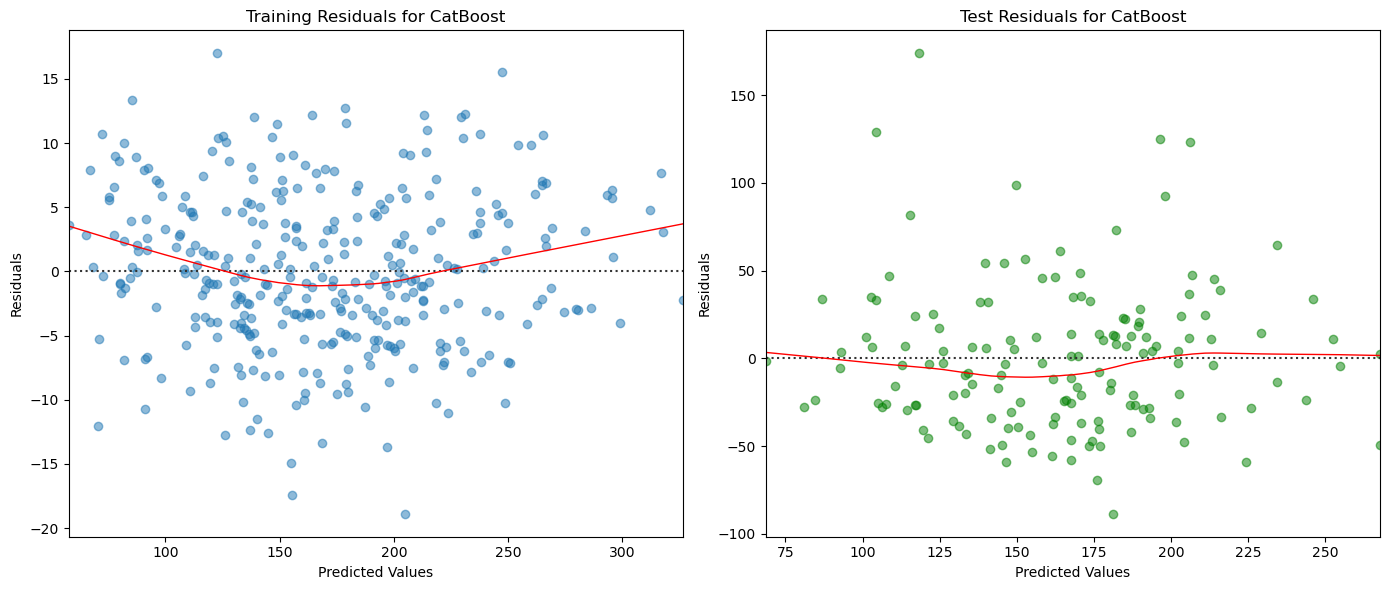


Residual Analysis:
Mean of training residuals: 0.0054
Mean of test residuals: 1.1081
Standard deviation of training residuals: 6.8716
Standard deviation of test residuals: 41.0069

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity
==== XGBoost Evaluation ====
Training MSE: 0.8895
Test MSE: 1876.6326
Training RMSE: 0.9431
Test RMSE: 43.3201
Training MAE: 0.6434
Test MAE: 32.8670
Training R²: 0.9998
Test R²: 0.4056


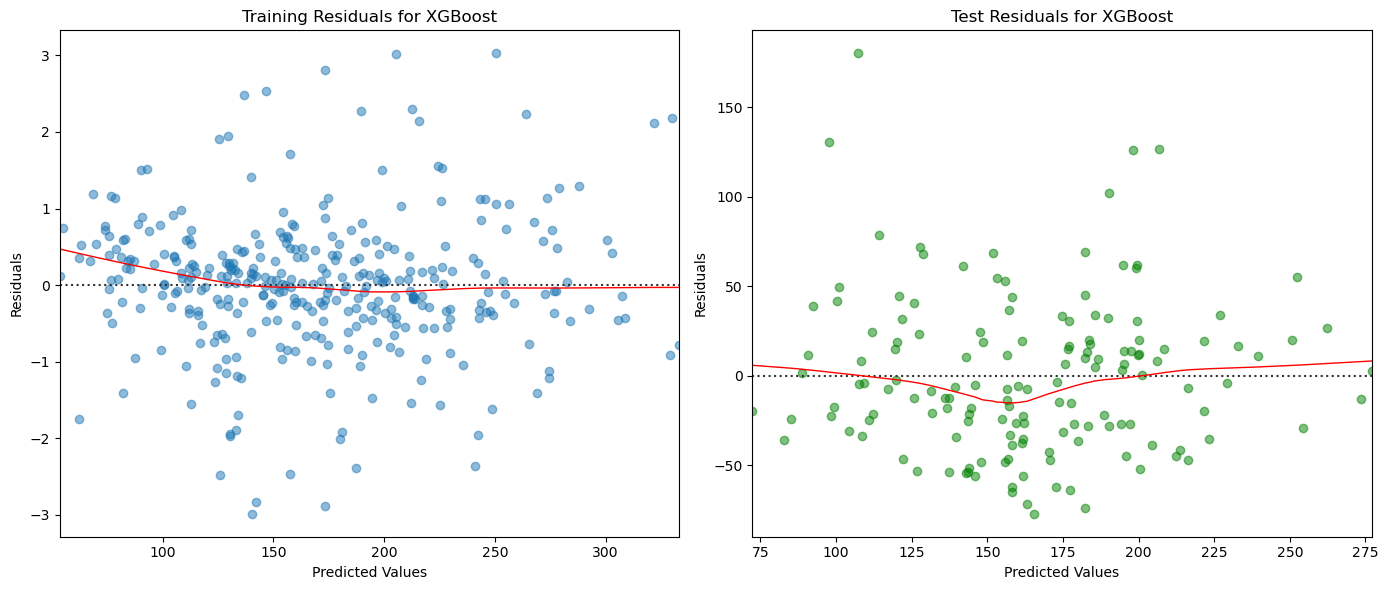


Residual Analysis:
Mean of training residuals: 0.0034
Mean of test residuals: 0.9820
Standard deviation of training residuals: 0.9431
Standard deviation of test residuals: 43.3090

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 350, number

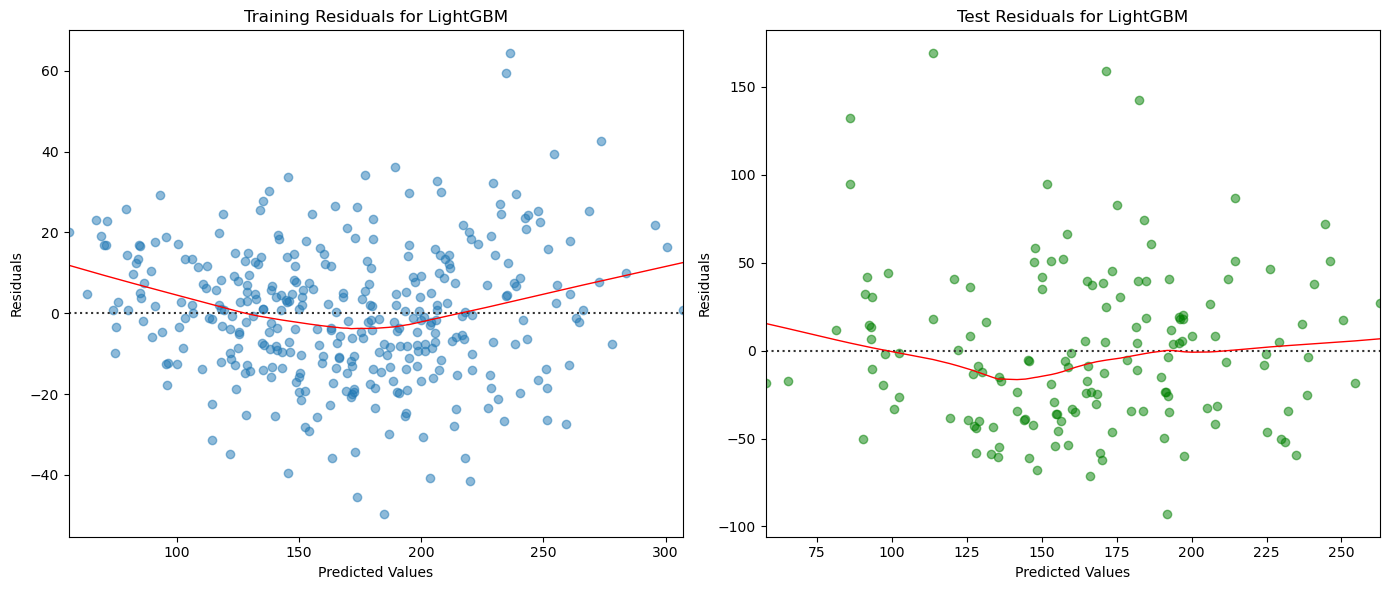


Residual Analysis:
Mean of training residuals: -0.0000
Mean of test residuals: 0.4007
Standard deviation of training residuals: 17.6756
Standard deviation of test residuals: 46.6236

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity
==== DecisionTree Evaluation ====
Training MSE: 0.0000
Test MSE: 2891.0114
Training RMSE: 0.0000
Test RMSE: 53.7681
Training MAE: 0.0000
Test MAE: 40.9017
Training R²: 1.0000
Test R²: 0.0843


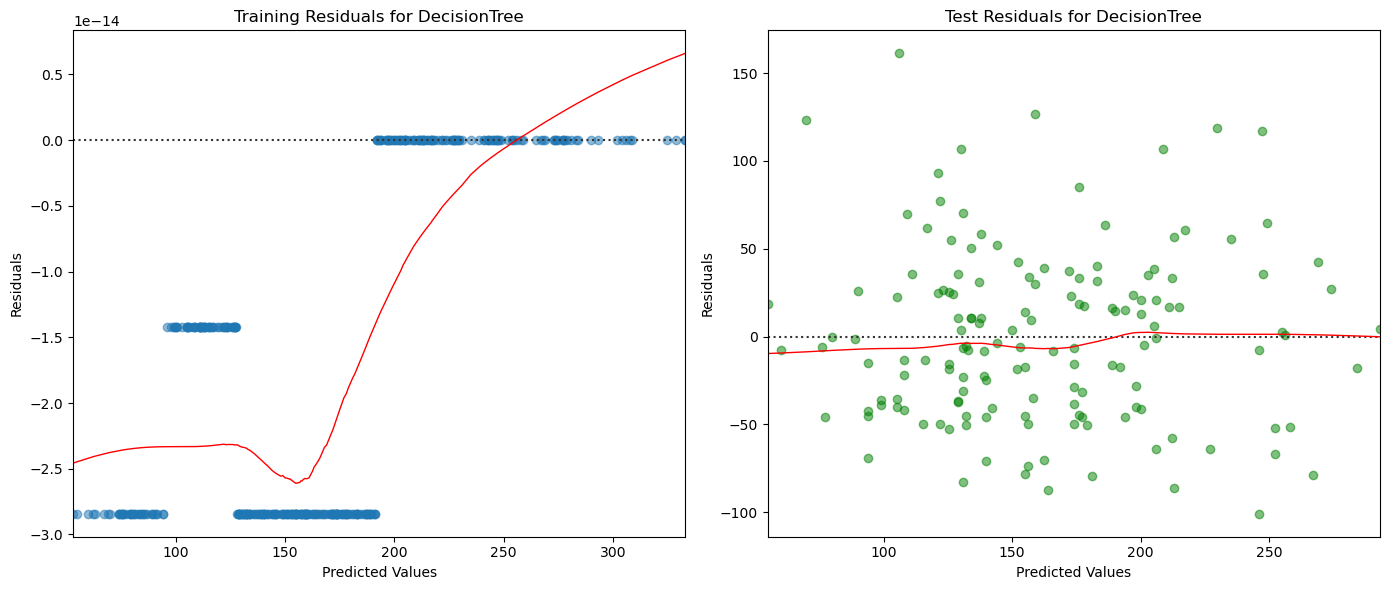


Residual Analysis:
Mean of training residuals: 0.0000
Mean of test residuals: 2.9133
Standard deviation of training residuals: 0.0000
Standard deviation of test residuals: 53.6891

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity
==== GaussianProcess Evaluation ====
Training MSE: 0.0000
Test MSE: 30275.8520
Training RMSE: 0.0000
Test RMSE: 173.9996
Training MAE: 0.0000
Test MAE: 164.5960
Training R²: 1.0000
Test R²: -8.5896


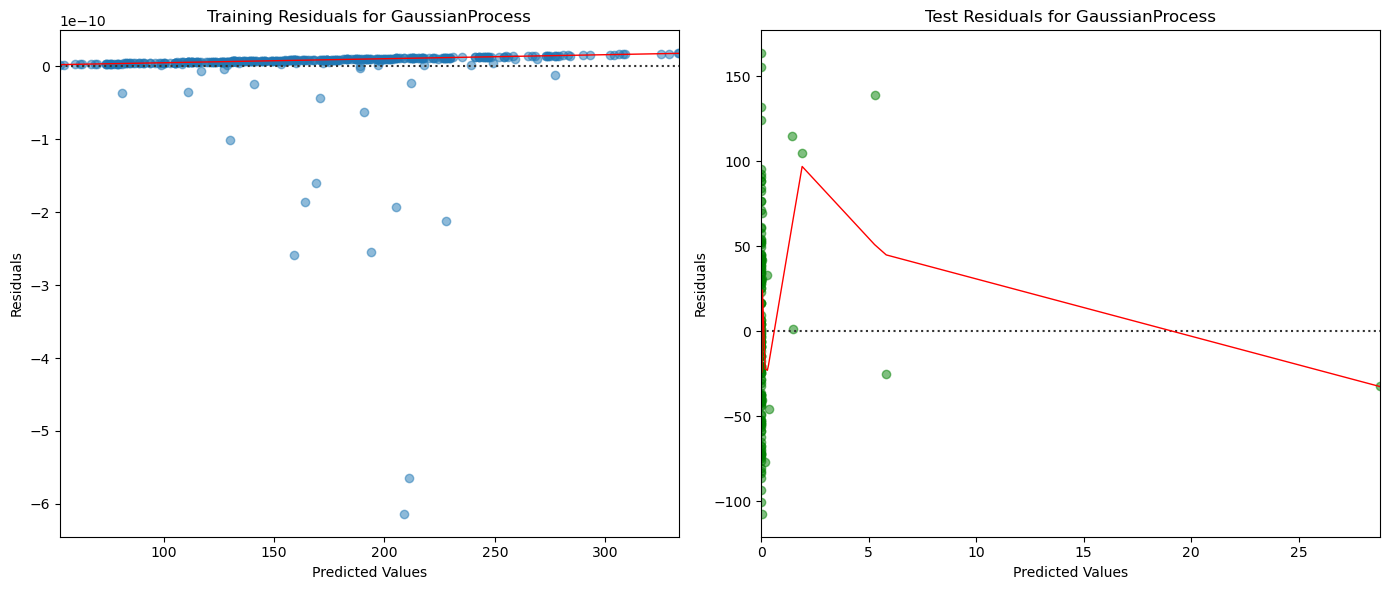


Residual Analysis:
Mean of training residuals: 0.0000
Mean of test residuals: 164.5960
Standard deviation of training residuals: 0.0000
Standard deviation of test residuals: 56.4269

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity
==== RandomForest Evaluation ====
Training MSE: 238.4576
Test MSE: 2002.1005
Training RMSE: 15.4421
Test RMSE: 44.7448
Training MAE: 11.3671
Test MAE: 35.1435
Training R²: 0.9331
Test R²: 0.3659


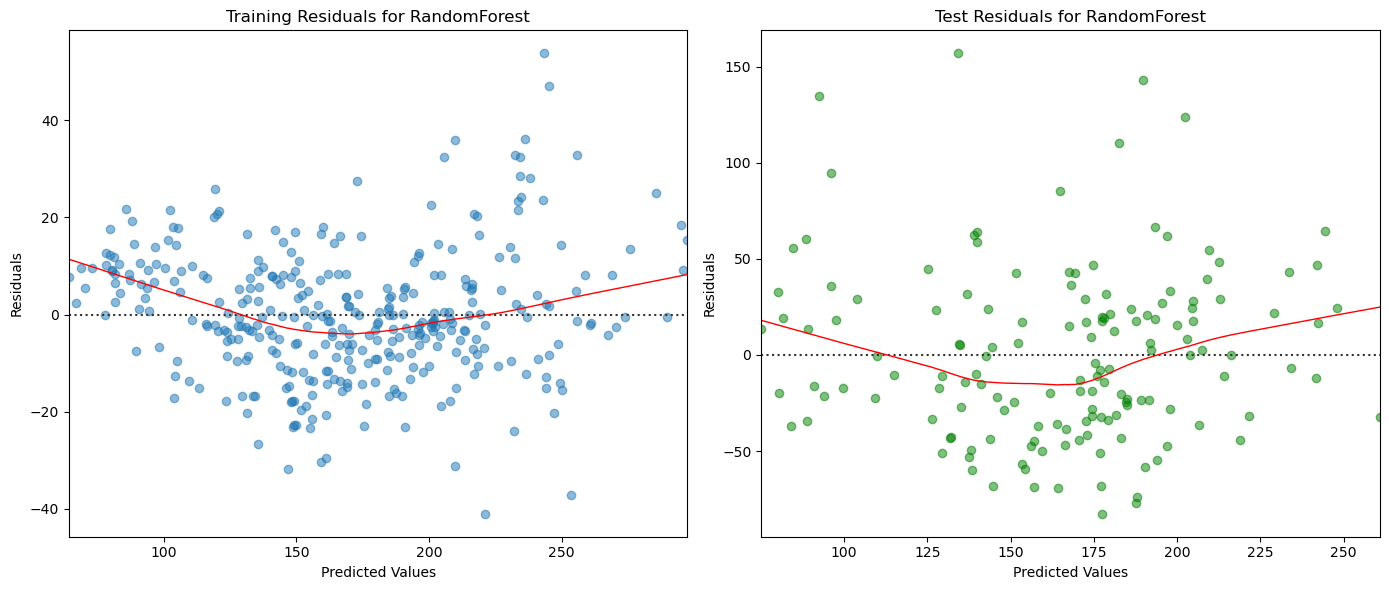


Residual Analysis:
Mean of training residuals: -0.1538
Mean of test residuals: -0.2655
Standard deviation of training residuals: 15.4413
Standard deviation of test residuals: 44.7440

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity
==== LinearRegression Evaluation ====
Training MSE: 923.1571
Test MSE: 2217.2005
Training RMSE: 30.3835
Test RMSE: 47.0872
Training MAE: 22.0096
Test MAE: 37.2585
Training R²: 0.7410
Test R²: 0.2977


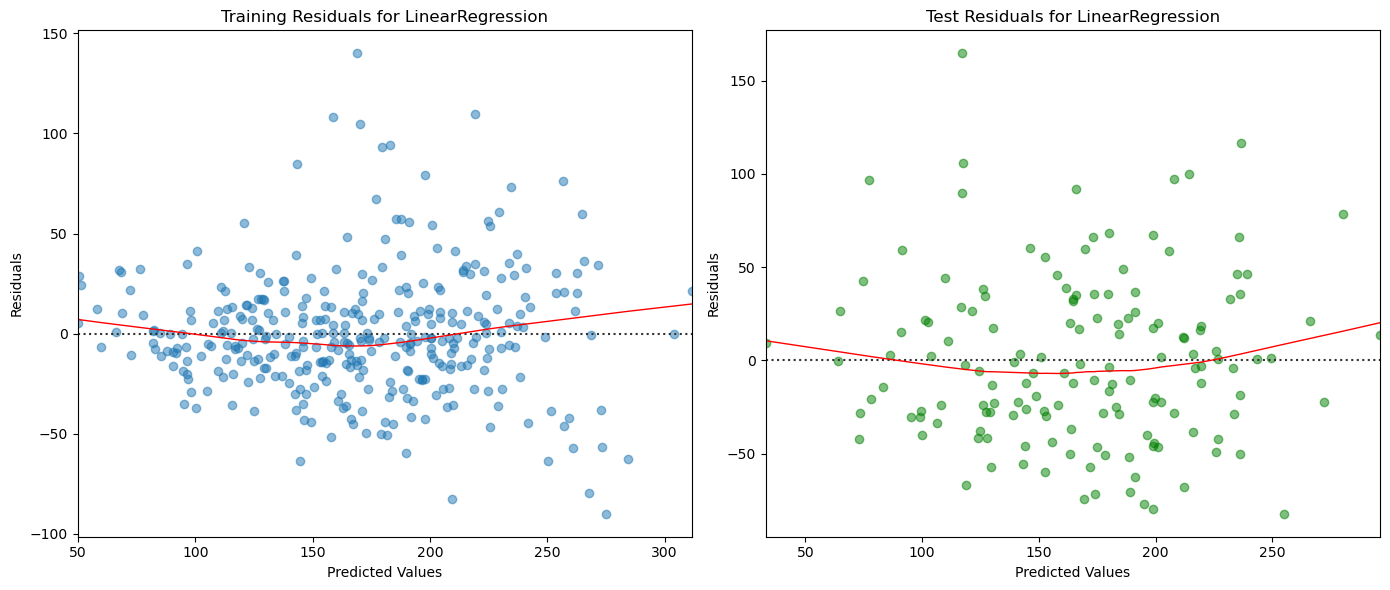


Residual Analysis:
Mean of training residuals: -0.0125
Mean of test residuals: -2.2218
Standard deviation of training residuals: 30.3835
Standard deviation of test residuals: 47.0347

Conclusion:
- Residuals are not centered around zero, suggesting potential bias in predictions.
- Model shows signs of overfitting (performs much better on training data than test data).
- Examining the residual plots:
  * A relatively flat lowess line indicates good fit
  * An upward or downward trend suggests systematic bias
  * Varying dispersion at different predicted values suggests heteroscedasticity


In [63]:
models = {
    "CatBoost": CatBoostRegressor(verbose=0),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "GaussianProcess": GaussianProcessRegressor(),
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression()
}

for model_name, model in models.items():
    plot_residual(model, X, y, X_test, y_test, model_name=model_name)

## Analyzing results using SHAP values and feature importance  

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def analyze_single_model(model, X, y, n_top_features=15, model_name="Model"):
    """
    Analyze a single model by displaying feature importance and SHAP values.

    Parameters:
    model : The trained model to analyze
    X : pandas DataFrame
        The feature dataset
    y : pandas Series or numpy array
        The target variable
    n_top_features : int, optional (default=15)
        Number of top features to display in plots
    model_name : str, optional (default="Model")
        Name of the model for plot titles
    """

    feature_names = X.columns

    def plot_feature_importance(importances, title, ax):
        # Sort importances in descending order for plotting
        indices = np.argsort(importances)[::-1][:n_top_features]
        top_importances = importances[indices]
        top_features = [feature_names[i] for i in indices]

        colors = cm.Blues(np.linspace(0.5, 1, len(top_importances)))

        bars = ax.bar(top_features, top_importances, color=colors)
        ax.set_title(title)
        ax.set_xticks(range(len(top_features)))
        ax.set_xticklabels(top_features, rotation=90)

        # Add value labels at the top of each bar
        for bar, imp in zip(bars, top_importances):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{imp:.2f}',
                    ha='center', va='bottom', color='black', fontweight='bold')

    def get_feature_importance(model):
        if hasattr(model, 'feature_importances_'):
            return model.feature_importances_
        elif isinstance(model, LinearRegression):
            return np.abs(model.coef_)
        else:
            return None

    def get_shap_values(model, X):
        if isinstance(model, (RandomForestRegressor)) or type(model).__name__ in ['LinearRegression', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor']:
            explainer = shap.TreeExplainer(model)
            return explainer.shap_values(X)

    # Feature Importance Plot
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    importances = get_feature_importance(model)
    if importances is not None:
        plot_feature_importance(importances, f"Feature Importance - {model_name}", ax1)
    else:
        ax1.text(0.5, 0.5, "Feature importance not available", ha='center', va='center')

    plt.tight_layout()
    plt.show()

    # SHAP Values Beeswarm Plot
    try:
        shap_values = get_shap_values(model, X)
        plt.figure(figsize=(8, 6))
        shap.summary_plot(shap_values, X, plot_type="dot", max_display=n_top_features, show=False)
        plt.show() # added plt.show()
    except Exception as e:
        print(f"Error computing SHAP values for {model_name}: {e}")

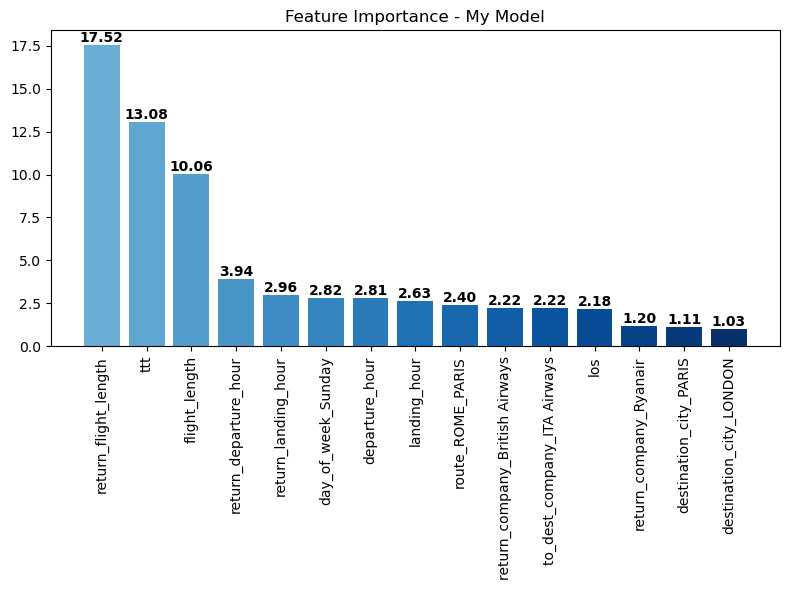

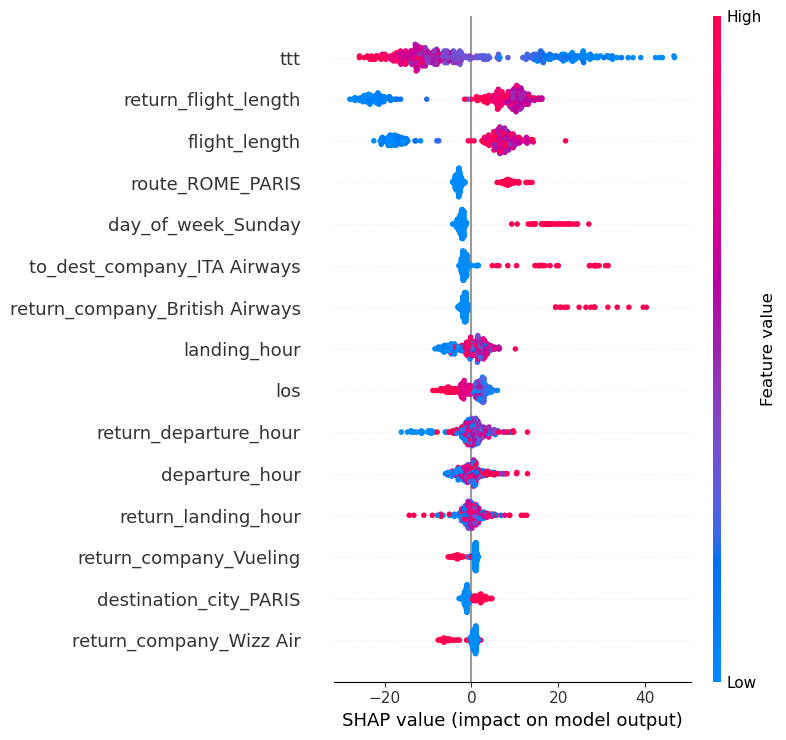

In [160]:
# Example usage for CatBoost
#catboost = CatBoostRegressor(**catboost_best_params, verbose=0, early_stopping_rounds=50)
catboost = CatBoostRegressor(verbose=0, early_stopping_rounds=50)

catboost.fit(X, y)

analyze_single_model(catboost, X, y, model_name="My Model")

<h2>Seperate data based on website</h2>
In the following section we will create 

In [161]:
# Conver dtype to string
sample["departure_date"] = sample["departure_date"].astype(str)

convert_object_to_category(sample)
sample = categorical_encoding(sample)

In [162]:
data_kayak = sample[sample["website_Kayak"]].copy()
data_kiwi = sample[sample["website_Kiwi"]].copy()

# Split into Training and Testing (Kayak)
X_kayak = data_kayak.drop("price", axis=1)
y_kayak = data_kayak["price"]
X_kayak_train, X_kayak_test, y_kayak_train, y_kayak_test = train_test_split(
    X_kayak, y_kayak, test_size=0.3, random_state=random_state
)

# Split into Training and Testing (Kiwi)
X_kiwi = data_kiwi.drop("price", axis=1)
y_kiwi = data_kiwi["price"]
X_kiwi_train, X_kiwi_test, y_kiwi_train, y_kiwi_test = train_test_split(
    X_kiwi, y_kiwi, test_size=0.3, random_state=random_state
)

In [163]:
print("Kayak Training Data:")
print("X_kayak_train shape:", X_kayak_train.shape)
print("y_kayak_train shape:", y_kayak_train.shape)
print("Kayak Testing Data:")
print("X_kayak_test shape:", X_kayak_test.shape)
print("y_kayak_test shape:", y_kayak_test.shape)

print("\nKiwi Training Data:")
print("X_kiwi_train shape:", X_kiwi_train.shape)
print("y_kiwi_train shape:", y_kiwi_train.shape)
print("Kiwi Testing Data:")
print("X_kiwi_test shape:", X_kiwi_test.shape)
print("y_kiwi_test shape:", y_kiwi_test.shape)

Kayak Training Data:
X_kayak_train shape: (285, 161)
y_kayak_train shape: (285,)
Kayak Testing Data:
X_kayak_test shape: (123, 161)
y_kayak_test shape: (123,)

Kiwi Training Data:
X_kiwi_train shape: (64, 161)
y_kiwi_train shape: (64,)
Kiwi Testing Data:
X_kiwi_test shape: (28, 161)
y_kiwi_test shape: (28,)


In [172]:
print("models evaluation - Kayak site")

evalution_func(X_kayak_train, y_kayak_train)

print("models evaluation - Kiwi site")

evalution_func(X_kiwi_train, y_kiwi_train)

models evaluation - Kayak site


MSE              RMSE             MAE  \
0                  1931.6543          -43.8157         32.7917   
1                  2653.4583          -51.3478         39.5572   
2                  2131.1728          -46.0589         35.1613   
3                  2191.0214          -46.9984         35.5578   
4 266894342807726489600.0000 -13317456637.1685 2528025058.8943   
5                  3854.2070          -62.8189         48.5860   
6                 31631.7117         -177.6962        167.9134   

                       R2                 Algorithm  
0                  0.4272         CatBoostRegressor  
1                  0.2084             LGBMRegressor  
2                  0.3671              XGBRegressor  
3                  0.3247     RandomForestRegressor  
4 -81339238123494608.0000          LinearRegression  
5                 -0.2542     DecisionTreeRegressor  
6                 -8.4354  GaussianProcessRegressor

Evaluation time: 41.61224865913391 seconds
models evaluation - Kiwi site


MSE      RMSE      MAE       R2                 Algorithm
0  1470.8559  -37.7172  33.5273   0.2807         CatBoostRegressor
1  1649.0342  -40.0204  34.5040   0.1972             LGBMRegressor
2  1930.5161  -43.6512  35.9510  -0.0293              XGBRegressor
3  1736.6211  -40.1678  34.4108   0.1379     RandomForestRegressor
4  6836.4003  -74.3126  50.8945  -1.9661          LinearRegression
5  2430.1796  -53.5514  43.6887  -0.3551     DecisionTreeRegressor
6 27460.5608 -165.3448 158.6897 -12.8705  GaussianProcessRegressor

Evaluation time: 21.646118879318237 seconds


In [170]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name="CatBoost", random_state=42):

    catboost_model = CatBoostRegressor(verbose=0, random_state=random_state)
    catboost_model.fit(X_train, y_train)
    
    y_pred = catboost_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} CatBoost prediction Results:")
    print(f"The RMSE score is: {rmse:.4f}")
    print(f"The MSE score is: {mse:.4f}")
    print(f"The MAE score is: {mae:.4f}")
    print(f"The R2 Score is: {r2:.4f}")

    analyze_single_model(catboost_model, X_kayak_train, y_kayak_train, model_name="catboost_kayak")

    return {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

Kayak CatBoost prediction Results:
The RMSE score is: 41.3041
The MSE score is: 1706.0314
The MAE score is: 31.8054
The R2 Score is: 0.5768


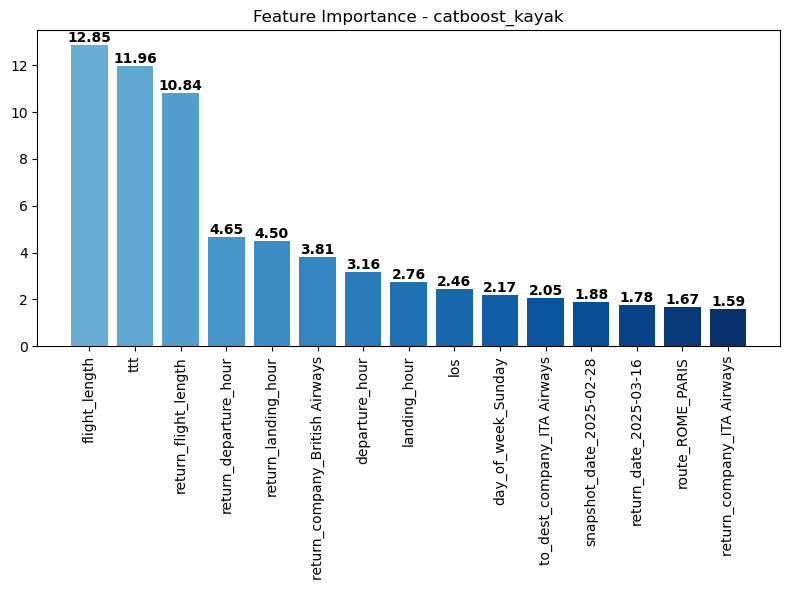

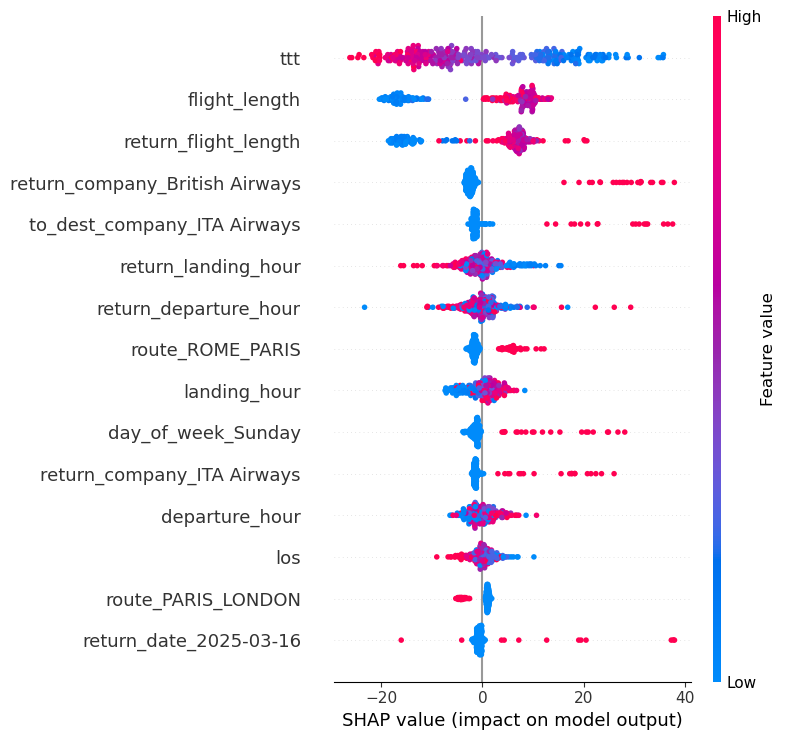

Kiwi CatBoost prediction Results:
The RMSE score is: 46.1434
The MSE score is: 2129.2108
The MAE score is: 34.7849
The R2 Score is: 0.2800


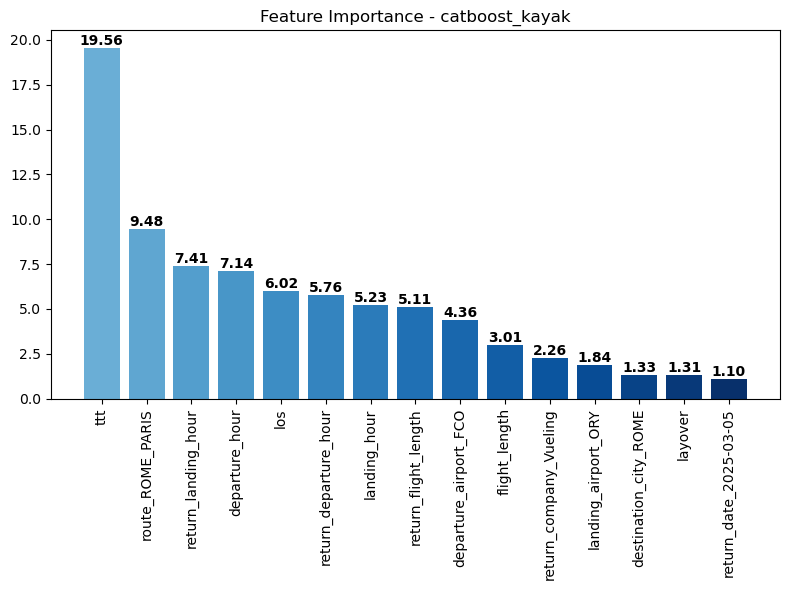

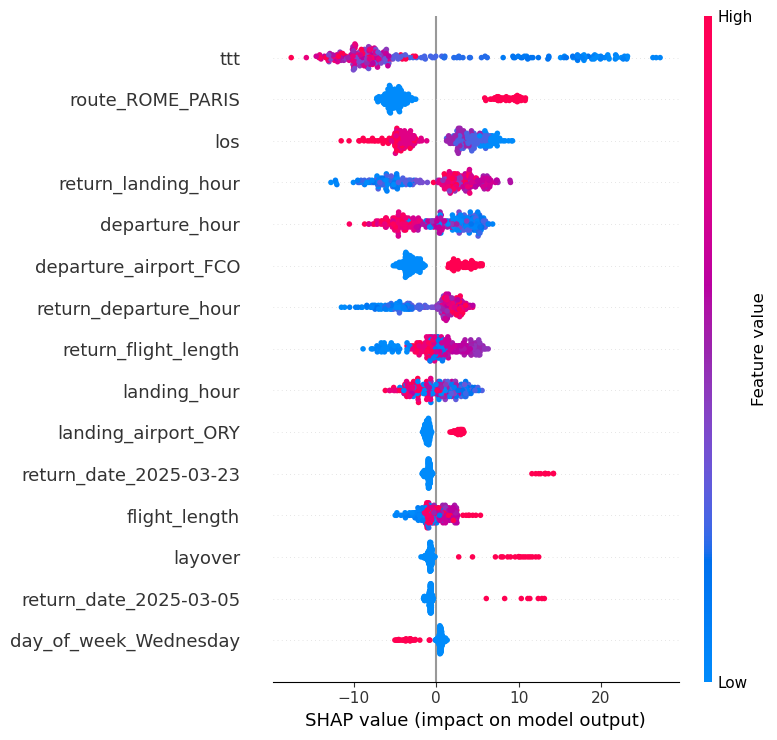

In [171]:
results_kayak = train_and_evaluate_model(X_kayak_train, y_kayak_train, X_kayak_test, y_kayak_test, model_name="Kayak")
results_kiwi = train_and_evaluate_model(X_kiwi_train, y_kiwi_train, X_kiwi_test, y_kiwi_test, model_name="Kiwi")

<h3>Train Test Split based on TTT</h3>
In this section we will split into train and test based on the ttt feature, all the ttt values over 25 will be in the test and under or equal 25 will be in train

In [195]:
ttt_train = sample[sample['ttt']<=25]
ttt_test = sample[sample['ttt']>25]

ttt_train_y = ttt_train.price
ttt_train_X = ttt_train.drop(["price"], axis=1)

ttt_test_y = ttt_test.price
ttt_test_X = ttt_test.drop(["price"], axis=1)

print("models evaluation - ttt split")

evalution_func(ttt_train_X, ttt_train_y)

models evaluation - ttt split


MSE      RMSE      MAE      R2                 Algorithm
0  1591.8233  -39.7657  30.2322  0.5472         CatBoostRegressor
1  1959.0085  -44.1410  34.0812  0.4393             LGBMRegressor
2  1983.2241  -44.3558  32.8760  0.4358              XGBRegressor
3  1866.4117  -43.0206  32.9533  0.4827     RandomForestRegressor
4  2341.2759  -48.2659  37.2958  0.3309          LinearRegression
5  3256.6611  -57.0707  41.8169  0.0922     DecisionTreeRegressor
6 31899.4844 -178.4523 168.3623 -8.1846  GaussianProcessRegressor

Evaluation time: 49.2709321975708 seconds


Kayak CatBoost prediction Results:
The RMSE score is: 36.3169
The MSE score is: 1318.9141
The MAE score is: 30.3887
The R2 Score is: 0.3227


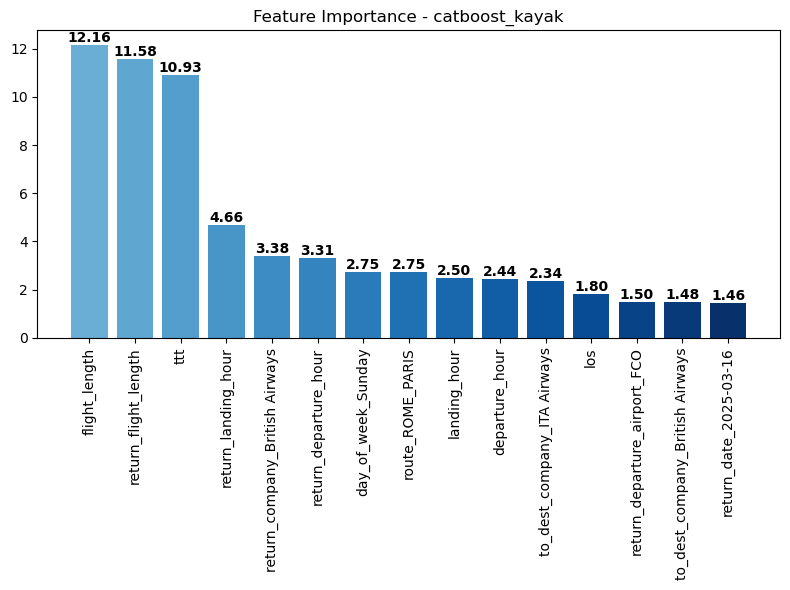

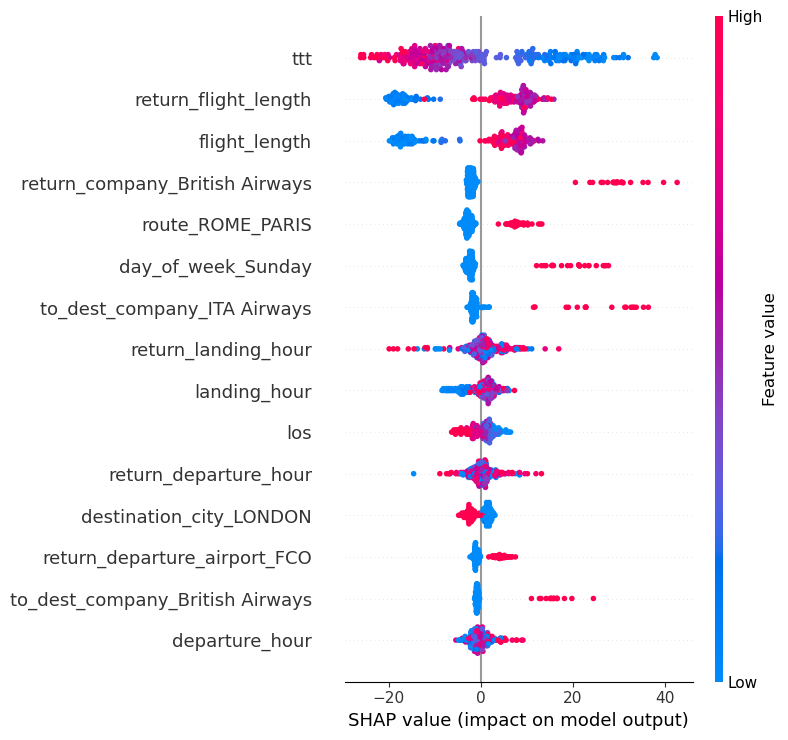

In [196]:
results_kayak = train_and_evaluate_model(ttt_train_X, ttt_train_y, ttt_test_X, ttt_test_y, model_name="Kayak")

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor

def plot_catboost_r2_distribution(model, df, flight_id_col='flight_id', target_col='price'):

    # Make predictions
    X = df.drop(target_col, axis=1)
    y_true = df[target_col]
    y_pred = model.predict(X)

    # Create a DataFrame to store the data
    results_df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'flight_id': ttt_train[flight_id_col]
    })

    # Calculate R2 for each flight
    r2_scores = results_df.groupby('flight_id').apply(lambda x: r2_score(x['y_true'], x['y_pred']))

    # Plot the distribution of R2 scores
    plt.figure(figsize=(10, 6))
    sns.histplot(r2_scores, kde=True, color='skyblue')
    plt.title('Distribution of R2 Scores across Flights (CatBoost)')
    plt.xlabel('R2 Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example Usage (replace with your trained CatBoost model and DataFrame):
# Assuming you have:
# catboost_best_model: Your trained CatBoostRegressor model

catboost_best_model = CatBoostRegressor(verbose=0, random_state=random_state)
catboost_best_model.fit(ttt_train.drop(columns='price'), ttt_train['price'])
    
y_pred = catboost_best_model.predict(X_test)

plot_catboost_r2_distribution(catboost_best_model, ttt_train)

KeyError: 'flight_id'

In [186]:
ttt_train.columns

Index(['departure_hour', 'flight_length', 'landing_hour',
       'return_departure_hour', 'return_flight_length', 'return_landing_hour',
       'price', 'layover', 'ttt', 'los',
       ...
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'route_LONDON_PARIS', 'route_LONDON_ROME',
       'route_PARIS_LONDON', 'route_PARIS_ROME', 'route_ROME_LONDON',
       'route_ROME_PARIS'],
      dtype='object', length=162)

In [194]:
sample.head()

departure_hour  flight_length  landing_hour  return_departure_hour  \
198468         21.6667            115       23.5833                 6.6667   
339085         10.0833            130       12.2500                21.6667   
275911         10.0833            165       11.8333                 9.1667   
339806         12.0833            135       14.3333                 7.3333   
108536         14.1667             75       14.4167                13.7500   

        return_flight_length  return_landing_hour    price  layover  ttt  los  \
198468                   135               8.9167 217.0000    False    5    1   
339085                   115              23.5833 174.0000    False   15    3   
275911                   150              12.6667 235.0000    False    8    3   
339806                   120               9.3333 304.0000    False   15    5   
108536                    75              16.0000 156.0000    False    9    1   

        ...  day_of_week_Sunday  day_of_week_Thursday  day_of_week_Tuesday  \
198468  ...               False                  True                False   
339085  ...               False                 False                False   
275911  ...               False                 False                False   
339806  ...               False                 False                False   
108536  ...                True                 False                False   

        day_of_week_Wednesday  route_LONDON_PARIS  route_LONDON_ROME  \
198468                  False               False              False   
339085                  False               False              False   
275911                  False               False              False   
339806                  False               False              False   
108536                  False               False              False   

        route_PARIS_LONDON  route_PARIS_ROME  route_ROME_LONDON  \
198468               False              True              False   
339085               False             False              False   
275911               False             False               True   
339806               False             False              False   
108536                True             False              False   

        route_ROME_PARIS  
198468             False  
339085              True  
275911             False  
339806              True  
108536             False  

[5 rows x 162 columns]

In [ ]:
from sklearn.cluster import KMeans
